# Duck Egg Quality Classification Based on its Shell Visual Property through Image Processing and Deep Learning


Group CGM: <br>

Caguioa, JV Bryan <br>
Guinto, Ryhle Nodnyhlson <br>
Mesias, Lee Reuben

# References

https://thedatafrog.com/en/articles/image-recognition-transfer-learning/ <br>
https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538 <br>
https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python <br>
https://keras.io/examples/vision/grad_cam/

## Imports

In [203]:
# the directory where the data is stored
directory = "C:/Users/user/Desktop/Dataset"
#directory where set of models per training are stored
gen_dir = "C:/Users/user/Desktop/Model"

import os                                              # define and move to dataset and model directory
import random                                          # for image name
import shutil                                          # dupli
import sys
import cv2     

import tensorflow.keras as keras
import numpy as np
import tensorflow as tf                                 #for callbacks
import seaborn as sn
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt                         #histograph/confusion matrix

from sklearn.model_selection import StratifiedKFold     #k-fold cross validation
from sklearn.model_selection import train_test_split    #split the dataset to train-test

from tensorflow.keras.preprocessing.image import ImageDataGenerator      # data augmentation
from tensorflow.keras.preprocessing import image as im                   #load image
from tensorflow.keras.applications.resnet50 import preprocess_input      #preprocess image                                                               

#measure performance metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc       
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import label_binarize

from scipy import interp                            #interpolation needed for plotting all classes into one roc plot
from itertools import cycle                         #for the color of lines on that multiclass plot

#Grad-CAM
from IPython.display import Image, display
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

## Put Dataset in a Dataframe

The directory of the images are put in a dataframe in order to prepare for splitting the dataset into train and test set.

In [2]:
totaldsdirect = directory + "/CombinedTwoAngleEggs"

image = []

if not os.path.exists(totaldsdirect):
    print("Directory does not exist. Please run the code on data cleaning notebook.")
    sys.exit()

for x in os.listdir(totaldsdirect):
    totaldsdirect2 = totaldsdirect + "/" + x
    for y in os.listdir(totaldsdirect2):
        if x == "Balut-penoy2":
            lbl = "0"
        elif x == "Salted egg2":
            lbl = "1"
        else:
            lbl = "2"
                 
        #append to image array
        image.append([totaldsdirect2 + "/" + y,lbl])

In [3]:
df = pd.DataFrame(image,columns=['filename','label'])
df

,filename,label
0,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
1,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
2,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
3,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
4,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
...,...,...
595,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2
596,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2
597,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2
598,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2


Classes: <br>
0 - Balut/Penoy <br> 
1 - Salted <br>
2 - Table

## Split Data to train and test set

We will need to split the dataset to train and test set. Only the train set will be used for transfer learning with K-fold validation. Test set will be used for model prediction and use that for model evaluation. Stratify is used in order to split the data in equal numbers under the classes specified.

In [4]:
# Split the data to train and test
X = df[['filename']]
y = df[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=420)

Save the split sets to train and test set folders.

In [5]:
#folder to store the train and test set folders
fortraintest = directory + "/ToBeUsed"
if not os.path.exists(fortraintest):
    os.makedirs(fortraintest)

#train set folder
tr = fortraintest + "/train_set"
if not os.path.exists(tr):
    os.makedirs(tr)
else:
    #remove previous folder and create new one
    shutil.rmtree(tr)
    os.makedirs(tr)
    
#test set folder
te = fortraintest + "/test_set"
if not os.path.exists(te):
    os.makedirs(te)
else:
    #remove previous folder and create new one
    shutil.rmtree(te)
    os.makedirs(te)

#copying the images to the train set folder
for index, row in X_train.iterrows():
    trcpy = shutil.copy2(row['filename'], tr)
    X_train.loc[X_train['filename']==row['filename'],'filename']=trcpy #change to directory where image is copied
    
#copying the images to the test set folder
for index, row in X_test.iterrows():
    tecpy = shutil.copy2(row['filename'], te)
    X_test.loc[X_test['filename']==row['filename'],'filename']=tecpy #change to directory where image is copied

In [6]:
df2 = pd.concat([X_train,y_train],axis=1)
df2

,filename,label
11,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
581,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
377,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
487,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
216,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
...,...,...
273,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
486,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
86,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
200,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1


To check whether or not there are equal amounts of images per class in the train set, we have done what is shown below.

In [7]:
counto = [0,0,0]

counto_count = 0

for x in df2['label'].unique():
    for y in df2['label']:
        if x == y:
            if counto_count == 0:
                counto[0] += 1
            elif counto_count == 1:
                counto[1] += 1
            else:
                counto[2] += 1
                
    counto_count += 1

In [8]:
print(counto)

[180, 180, 180]


In [9]:
df3 = pd.concat([X_test,y_test],axis=1)
df3

,filename,label
177,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,0
535,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
563,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
498,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
502,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
257,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,1
559,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
134,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,0
298,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,1
10,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,0


Same with the train set, we checked whether or not there is an equal distribution of images

In [10]:
counto = [0,0,0]

counto_count = 0

for x in df3['label'].unique():
    for y in df3['label']:
        if x == y:
            if counto_count == 0:
                counto[0] += 1
            elif counto_count == 1:
                counto[1] += 1
            else:
                counto[2] += 1
                
    counto_count += 1

In [11]:
print(counto)

[20, 20, 20]


## Functions

### Create Plot History

Plot history will display the training and validation accuracy, and training and validation loss in every epoch in a fold.

In [12]:
def plot_history(history, yrange):
    #Plot loss and accuracy as a function of the epoch,
    #for the training and validation datasets.
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.legend(['train_accuracy','val_accuracy'])
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.legend(['train_loss','val_loss'])
    
    plt.show() 

### Save Models

K-fold cross validation will be used in training the model.The set of models produced per fold will be saved in an automatic generated folder. Every training will generated another folder to save the new set of models.

In [13]:
def savemodel():
    save_cur = ""  #check if there is any saved_models folders

    svnum = 0
    svnum2 = 0

    for x in os.listdir(gen_dir):
        if "saved_models" in x:
            save_cur = x
            if not save_cur == "":
                for word in save_cur.split("_"):
                    if word.isdigit():
                        svnum2 = int(word)
                        if svnum < svnum2:
                            svnum = svnum2


    #save_dir is where the created models using the current set of hyperparameters are added        
    if save_cur == "":
        save_dir = gen_dir + "/saved_models_1"
        os.makedirs(save_dir)
    else:
        save_dir = gen_dir + "/saved_models_" + str(svnum + 1)
        os.makedirs(save_dir)
        
    return save_dir

## Data Augmentation

We will apply data augmentation to the dataset to increase the accuracy. We will use data augmentation per epoch in order to generate unique images in order to increase the dataset.

In [14]:
resnet50 = keras.applications.resnet50

imgdatagen = ImageDataGenerator(
        preprocessing_function = resnet50.preprocess_input,
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = 10,
        height_shift_range = 10,
        rotation_range = 5,
        brightness_range = [0.8,1.3],
        fill_mode = "nearest"
    )

## Model Creation

The model will be based on ResNet50 Architecture. The classifier block will be changed to suit to our dataset.

In [15]:
def create_model():
    conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

    for layer in conv_model.layers:
        layer.trainable = False

    x = keras.layers.GlobalAveragePooling2D()(conv_model.output)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    predictions = keras.layers.Dense(3, activation='softmax')(x)

    full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

    return full_model

In [16]:
full_model = create_model()
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Hyperparameter Tuning

We will check the combination of hyperparameters that yielded the best validation accuracy. A set of values on chosen hyperparameters is given. The one that will yield the best validation accuracy will be used to train the final model.

### Model Hyperparameters

In [17]:
batch_size_arr = [8]                                #batch size
num_epochs_arr = [110]                              #number of epochs
lr_arr = [0.0001]                                   #learning rate Adamax

### Initialize Variables

In [18]:
VALIDATION_ACCURACY = []                          #holds all validation_accuracy
VALIDATION_LOSS = []                              #holds all validation_loss

TRAIN_ACCURACY = []                               #holds all train_accuracy
TRAIN_LOSS = []                                   #holds all train_loss

TEST_ACCURACY = []                                #holds all test_accuracy
TEST_LOSS = []                                    #holds all test_loss

param_arr = []                                    #holds the hyperparameter values per combination

val_acc_arr = []                                  #holds the set of validation accuracy per combination
val_loss_arr = []                                 #holds the set of validation loss per combination
val_acc_means = []                                #holds the means of all set of validation accuracy per combination
val_loss_means = []                               #holds the means of all set of validation loss per combination

train_acc_arr = []                                #holds the set of train accuracy per combination
train_loss_arr = []                               #holds the set of train loss per combination
train_acc_means = []                              #holds the means of all set of train accuracy per combination
train_loss_means = []                             #holds the means of all set of train loss per combination

test_acc_arr = []                                 #holds the set of test accuracy per combination
test_loss_arr = []                                #holds the set of test loss per combination
test_acc_means = []                               #holds the means of all set of test accuracy per combination
test_loss_means = []                              #holds the means of all set of test loss per combination

### Train, Validation, Test data settings

In [19]:
train_dir = directory + "/ToBeUsed/train_set"     #where the train set images are stored
test_dir = directory + "/ToBeUsed/test_set"

#kfold parameters
Y = df2[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 69, shuffle = True)

#to get the train set images
trainX = []

for img_path in X_train['filename']:
    img = im.load_img(img_path, target_size=(224,224))
    x = im.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = x.reshape(224,224,3)
    trainX.append(x)

trainX = np.array(trainX)

#to get the test set images
testX = []

for img_path in X_test['filename']:
    img = im.load_img(img_path, target_size=(224,224))
    x = im.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = x.reshape(224,224,3)
    testX.append(x)

testX = np.array(testX)

ytr = pd.to_numeric(y_train['label'])
yt = pd.to_numeric(y_test['label'])                #make the labels to integer to get the model metrics

Train the model per combination of hyperparameters.


batch size:  8
epochs:  110
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/110
54/54 [==============================] - 14s 175ms/step - loss: 1.0487 - accuracy: 0.4861 - val_loss: 0.9985 - val_accuracy: 0.4167

Epoch 00001: val_accuracy improved from -inf to 0.41667, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5
Epoch 2/110
54/54 [==============================] - 8s 141ms/step - loss: 0.8735 - accuracy: 0.6181 - val_loss: 0.8387 - val_accuracy: 0.6389

Epoch 00002: val_accuracy improved from 0.41667 to 0.63889, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5
Epoch 3/110
54/54 [==============================] - 8s 142ms/step - loss: 0.7824 - accuracy: 0.6551 - val_loss: 0.7628 - val_accuracy: 0.7130

Epoch 00003: val_accuracy improved from 0.63889 to 0.71296, saving model to C:/Users/user/Desktop/Model/saved_models_1\mod

54/54 [==============================] - 9s 158ms/step - loss: 0.5069 - accuracy: 0.7894 - val_loss: 0.4643 - val_accuracy: 0.7870

Epoch 00038: val_accuracy did not improve from 0.85185
Epoch 39/110
54/54 [==============================] - 10s 179ms/step - loss: 0.4837 - accuracy: 0.8194 - val_loss: 0.4644 - val_accuracy: 0.8056

Epoch 00039: val_accuracy did not improve from 0.85185
Epoch 40/110
54/54 [==============================] - 9s 163ms/step - loss: 0.4936 - accuracy: 0.7917 - val_loss: 0.4861 - val_accuracy: 0.7685

Epoch 00040: val_accuracy did not improve from 0.85185
Epoch 41/110
54/54 [==============================] - 10s 178ms/step - loss: 0.4486 - accuracy: 0.8194 - val_loss: 0.3897 - val_accuracy: 0.8796

Epoch 00041: val_accuracy improved from 0.85185 to 0.87963, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5
Epoch 42/110
54/54 [==============================] - 9s 168ms/step - loss: 0.4133 - accuracy: 0.8403 - val_loss: 0.4339 - val_accuracy:

54/54 [==============================] - 12s 226ms/step - loss: 0.4011 - accuracy: 0.8264 - val_loss: 0.5109 - val_accuracy: 0.7963

Epoch 00078: val_accuracy did not improve from 0.89815
Epoch 79/110
54/54 [==============================] - 10s 179ms/step - loss: 0.4286 - accuracy: 0.8380 - val_loss: 0.4021 - val_accuracy: 0.8241

Epoch 00079: val_accuracy did not improve from 0.89815
Epoch 80/110
54/54 [==============================] - 9s 162ms/step - loss: 0.4008 - accuracy: 0.8519 - val_loss: 0.4716 - val_accuracy: 0.8056

Epoch 00080: val_accuracy did not improve from 0.89815
Epoch 81/110
54/54 [==============================] - 11s 196ms/step - loss: 0.3899 - accuracy: 0.8380 - val_loss: 0.3614 - val_accuracy: 0.8426

Epoch 00081: val_accuracy did not improve from 0.89815
Epoch 82/110
54/54 [==============================] - 11s 202ms/step - loss: 0.4405 - accuracy: 0.8241 - val_loss: 0.4607 - val_accuracy: 0.8056

Epoch 00082: val_accuracy did not improve from 0.89815
Epoch 83/

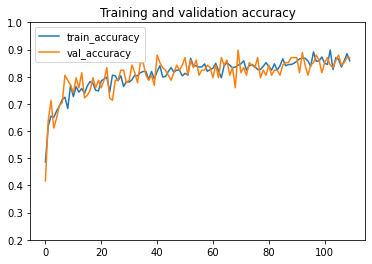

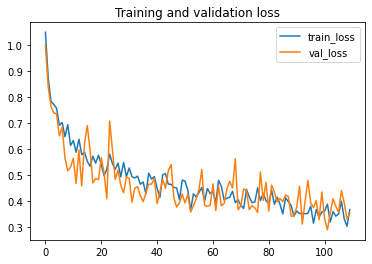

14/14 [==============================] - 2s 133ms/step - loss: 0.3668 - accuracy: 0.8426

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/110
54/54 [==============================] - 13s 175ms/step - loss: 1.1192 - accuracy: 0.4884 - val_loss: 1.0390 - val_accuracy: 0.5093

Epoch 00001: val_accuracy improved from -inf to 0.50926, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_2.h5
Epoch 2/110
54/54 [==============================] - 8s 152ms/step - loss: 0.8047 - accuracy: 0.6528 - val_loss: 0.9227 - val_accuracy: 0.6296

Epoch 00002: val_accuracy improved from 0.50926 to 0.62963, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_2.h5
Epoch 3/110
54/54 [==============================] - 9s 159ms/step - loss: 0.7291 - accuracy: 0.6782 - val_loss: 0.7923 - val_accuracy: 0.6944

Epoch 00003: val_accuracy improved from 0.62963 to 0.69444, saving model to C:/Users/u

54/54 [==============================] - 9s 158ms/step - loss: 0.4738 - accuracy: 0.8032 - val_loss: 0.4672 - val_accuracy: 0.7963

Epoch 00038: val_accuracy did not improve from 0.81481
Epoch 39/110
54/54 [==============================] - 8s 144ms/step - loss: 0.4858 - accuracy: 0.8194 - val_loss: 0.4327 - val_accuracy: 0.8148

Epoch 00039: val_accuracy did not improve from 0.81481
Epoch 40/110
54/54 [==============================] - 9s 164ms/step - loss: 0.5234 - accuracy: 0.7986 - val_loss: 0.4927 - val_accuracy: 0.7963

Epoch 00040: val_accuracy did not improve from 0.81481
Epoch 41/110
54/54 [==============================] - 9s 162ms/step - loss: 0.4583 - accuracy: 0.8148 - val_loss: 0.4853 - val_accuracy: 0.8333

Epoch 00041: val_accuracy improved from 0.81481 to 0.83333, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_2.h5
Epoch 42/110
54/54 [==============================] - 9s 161ms/step - loss: 0.4591 - accuracy: 0.8194 - val_loss: 0.5108 - val_accuracy: 0

54/54 [==============================] - 9s 165ms/step - loss: 0.4422 - accuracy: 0.8171 - val_loss: 0.5625 - val_accuracy: 0.7500

Epoch 00078: val_accuracy did not improve from 0.86111
Epoch 79/110
54/54 [==============================] - 9s 170ms/step - loss: 0.4135 - accuracy: 0.8310 - val_loss: 0.4957 - val_accuracy: 0.7685

Epoch 00079: val_accuracy did not improve from 0.86111
Epoch 80/110
54/54 [==============================] - 9s 160ms/step - loss: 0.3696 - accuracy: 0.8519 - val_loss: 0.4986 - val_accuracy: 0.7685

Epoch 00080: val_accuracy did not improve from 0.86111
Epoch 81/110
54/54 [==============================] - 9s 165ms/step - loss: 0.3815 - accuracy: 0.8426 - val_loss: 0.4333 - val_accuracy: 0.8148

Epoch 00081: val_accuracy did not improve from 0.86111
Epoch 82/110
54/54 [==============================] - 9s 169ms/step - loss: 0.3494 - accuracy: 0.8542 - val_loss: 0.5392 - val_accuracy: 0.7500

Epoch 00082: val_accuracy did not improve from 0.86111
Epoch 83/110


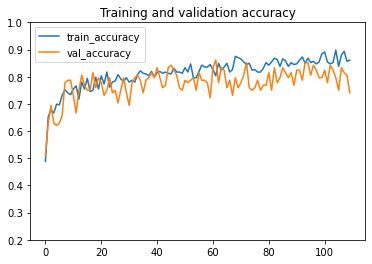

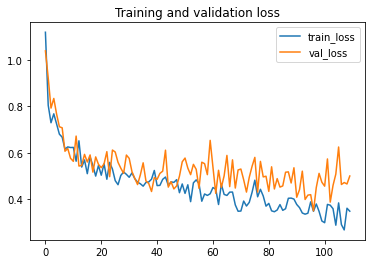

14/14 [==============================] - 2s 139ms/step - loss: 0.4361 - accuracy: 0.8241

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/110
54/54 [==============================] - 14s 204ms/step - loss: 1.1650 - accuracy: 0.4699 - val_loss: 1.0270 - val_accuracy: 0.5648

Epoch 00001: val_accuracy improved from -inf to 0.56481, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_3.h5
Epoch 2/110
54/54 [==============================] - 8s 156ms/step - loss: 0.9258 - accuracy: 0.5718 - val_loss: 0.8825 - val_accuracy: 0.6111

Epoch 00002: val_accuracy improved from 0.56481 to 0.61111, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_3.h5
Epoch 3/110
54/54 [==============================] - 10s 176ms/step - loss: 0.7901 - accuracy: 0.6065 - val_loss: 0.6871 - val_accuracy: 0.7500

Epoch 00003: val_accuracy improved from 0.61111 to 0.75000, saving model to C:/Users/

54/54 [==============================] - 10s 179ms/step - loss: 0.4758 - accuracy: 0.8056 - val_loss: 0.5378 - val_accuracy: 0.7870

Epoch 00038: val_accuracy did not improve from 0.81481
Epoch 39/110
54/54 [==============================] - 10s 178ms/step - loss: 0.5012 - accuracy: 0.7731 - val_loss: 0.4583 - val_accuracy: 0.8148

Epoch 00039: val_accuracy did not improve from 0.81481
Epoch 40/110
54/54 [==============================] - 9s 167ms/step - loss: 0.4767 - accuracy: 0.8194 - val_loss: 0.4563 - val_accuracy: 0.8056

Epoch 00040: val_accuracy did not improve from 0.81481
Epoch 41/110
54/54 [==============================] - 10s 177ms/step - loss: 0.4505 - accuracy: 0.8241 - val_loss: 0.5090 - val_accuracy: 0.7870

Epoch 00041: val_accuracy did not improve from 0.81481
Epoch 42/110
54/54 [==============================] - 10s 175ms/step - loss: 0.4817 - accuracy: 0.7963 - val_loss: 0.6341 - val_accuracy: 0.7593

Epoch 00042: val_accuracy did not improve from 0.81481
Epoch 43/

54/54 [==============================] - 10s 189ms/step - loss: 0.3560 - accuracy: 0.8519 - val_loss: 0.4166 - val_accuracy: 0.8241

Epoch 00078: val_accuracy did not improve from 0.86111
Epoch 79/110
54/54 [==============================] - 10s 192ms/step - loss: 0.3963 - accuracy: 0.8380 - val_loss: 0.4793 - val_accuracy: 0.7870

Epoch 00079: val_accuracy did not improve from 0.86111
Epoch 80/110
54/54 [==============================] - 12s 218ms/step - loss: 0.3731 - accuracy: 0.8472 - val_loss: 0.5828 - val_accuracy: 0.7870

Epoch 00080: val_accuracy did not improve from 0.86111
Epoch 81/110
54/54 [==============================] - 9s 157ms/step - loss: 0.3816 - accuracy: 0.8634 - val_loss: 0.4442 - val_accuracy: 0.8056

Epoch 00081: val_accuracy did not improve from 0.86111
Epoch 82/110
54/54 [==============================] - 9s 166ms/step - loss: 0.3754 - accuracy: 0.8611 - val_loss: 0.4578 - val_accuracy: 0.8148

Epoch 00082: val_accuracy did not improve from 0.86111
Epoch 83/1

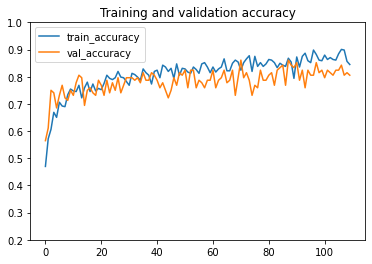

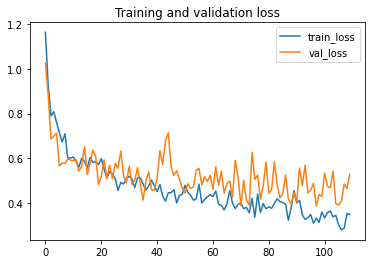

14/14 [==============================] - 2s 144ms/step - loss: 0.4061 - accuracy: 0.8241

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/110
54/54 [==============================] - 13s 185ms/step - loss: 1.0878 - accuracy: 0.5000 - val_loss: 1.1663 - val_accuracy: 0.3981

Epoch 00001: val_accuracy improved from -inf to 0.39815, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_4.h5
Epoch 2/110
54/54 [==============================] - 11s 199ms/step - loss: 0.9036 - accuracy: 0.5995 - val_loss: 0.9358 - val_accuracy: 0.5000

Epoch 00002: val_accuracy improved from 0.39815 to 0.50000, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_4.h5
Epoch 3/110
54/54 [==============================] - 11s 202ms/step - loss: 0.8352 - accuracy: 0.6157 - val_loss: 0.8523 - val_accuracy: 0.5741

Epoch 00003: val_accuracy improved from 0.50000 to 0.57407, saving model to C:/Users

54/54 [==============================] - 9s 171ms/step - loss: 0.4918 - accuracy: 0.8009 - val_loss: 0.4455 - val_accuracy: 0.8148

Epoch 00036: val_accuracy did not improve from 0.84259
Epoch 37/110
54/54 [==============================] - 9s 172ms/step - loss: 0.4481 - accuracy: 0.8241 - val_loss: 0.3772 - val_accuracy: 0.8426

Epoch 00037: val_accuracy did not improve from 0.84259
Epoch 38/110
54/54 [==============================] - 9s 172ms/step - loss: 0.4319 - accuracy: 0.8310 - val_loss: 0.4008 - val_accuracy: 0.8704

Epoch 00038: val_accuracy improved from 0.84259 to 0.87037, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_4.h5
Epoch 39/110
54/54 [==============================] - 9s 173ms/step - loss: 0.4390 - accuracy: 0.8056 - val_loss: 0.4551 - val_accuracy: 0.8056

Epoch 00039: val_accuracy did not improve from 0.87037
Epoch 40/110
54/54 [==============================] - 9s 169ms/step - loss: 0.4845 - accuracy: 0.7523 - val_loss: 0.3707 - val_accuracy: 0

54/54 [==============================] - 9s 169ms/step - loss: 0.4107 - accuracy: 0.8449 - val_loss: 0.3127 - val_accuracy: 0.8704

Epoch 00076: val_accuracy did not improve from 0.90741
Epoch 77/110
54/54 [==============================] - 9s 168ms/step - loss: 0.4377 - accuracy: 0.8333 - val_loss: 0.4576 - val_accuracy: 0.8241

Epoch 00077: val_accuracy did not improve from 0.90741
Epoch 78/110
54/54 [==============================] - 9s 170ms/step - loss: 0.3791 - accuracy: 0.8380 - val_loss: 0.3791 - val_accuracy: 0.8519

Epoch 00078: val_accuracy did not improve from 0.90741
Epoch 79/110
54/54 [==============================] - 9s 168ms/step - loss: 0.4033 - accuracy: 0.8333 - val_loss: 0.3924 - val_accuracy: 0.8519

Epoch 00079: val_accuracy did not improve from 0.90741
Epoch 80/110
54/54 [==============================] - 9s 168ms/step - loss: 0.4069 - accuracy: 0.8611 - val_loss: 0.3742 - val_accuracy: 0.8889

Epoch 00080: val_accuracy did not improve from 0.90741
Epoch 81/110


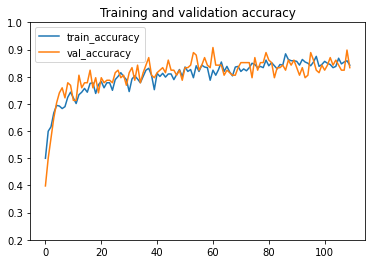

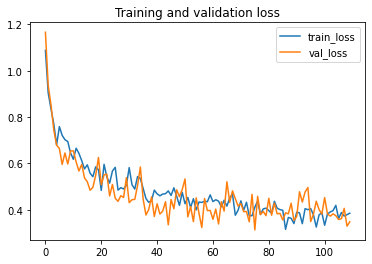

14/14 [==============================] - 2s 124ms/step - loss: 0.4848 - accuracy: 0.7963

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/110
54/54 [==============================] - 12s 168ms/step - loss: 1.0909 - accuracy: 0.5139 - val_loss: 1.0275 - val_accuracy: 0.4722

Epoch 00001: val_accuracy improved from -inf to 0.47222, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_5.h5
Epoch 2/110
54/54 [==============================] - 9s 165ms/step - loss: 0.9139 - accuracy: 0.5903 - val_loss: 0.9740 - val_accuracy: 0.5000

Epoch 00002: val_accuracy improved from 0.47222 to 0.50000, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_5.h5
Epoch 3/110
54/54 [==============================] - 9s 163ms/step - loss: 0.8068 - accuracy: 0.6042 - val_loss: 0.8519 - val_accuracy: 0.5648

Epoch 00003: val_accuracy improved from 0.50000 to 0.56481, saving model to C:/Users/u

54/54 [==============================] - 10s 191ms/step - loss: 0.5033 - accuracy: 0.7963 - val_loss: 0.4423 - val_accuracy: 0.8333

Epoch 00037: val_accuracy did not improve from 0.86111
Epoch 38/110
54/54 [==============================] - 10s 190ms/step - loss: 0.5030 - accuracy: 0.7847 - val_loss: 0.3887 - val_accuracy: 0.8241

Epoch 00038: val_accuracy did not improve from 0.86111
Epoch 39/110
54/54 [==============================] - 11s 207ms/step - loss: 0.5200 - accuracy: 0.8009 - val_loss: 0.4493 - val_accuracy: 0.8056

Epoch 00039: val_accuracy did not improve from 0.86111
Epoch 40/110
54/54 [==============================] - 11s 199ms/step - loss: 0.4797 - accuracy: 0.8056 - val_loss: 0.3581 - val_accuracy: 0.8241

Epoch 00040: val_accuracy did not improve from 0.86111
Epoch 41/110
54/54 [==============================] - 11s 203ms/step - loss: 0.4757 - accuracy: 0.8032 - val_loss: 0.3810 - val_accuracy: 0.8056

Epoch 00041: val_accuracy did not improve from 0.86111
Epoch 42

54/54 [==============================] - 10s 177ms/step - loss: 0.3690 - accuracy: 0.8380 - val_loss: 0.3654 - val_accuracy: 0.8056

Epoch 00077: val_accuracy did not improve from 0.90741
Epoch 78/110
54/54 [==============================] - 10s 184ms/step - loss: 0.3790 - accuracy: 0.8611 - val_loss: 0.4002 - val_accuracy: 0.8426

Epoch 00078: val_accuracy did not improve from 0.90741
Epoch 79/110
54/54 [==============================] - 9s 160ms/step - loss: 0.4338 - accuracy: 0.8218 - val_loss: 0.3220 - val_accuracy: 0.8889

Epoch 00079: val_accuracy did not improve from 0.90741
Epoch 80/110
54/54 [==============================] - 9s 169ms/step - loss: 0.4162 - accuracy: 0.8287 - val_loss: 0.3254 - val_accuracy: 0.8981

Epoch 00080: val_accuracy did not improve from 0.90741
Epoch 81/110
54/54 [==============================] - 8s 152ms/step - loss: 0.3492 - accuracy: 0.8611 - val_loss: 0.3350 - val_accuracy: 0.8611

Epoch 00081: val_accuracy did not improve from 0.90741
Epoch 82/11

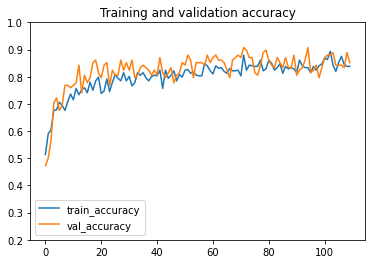

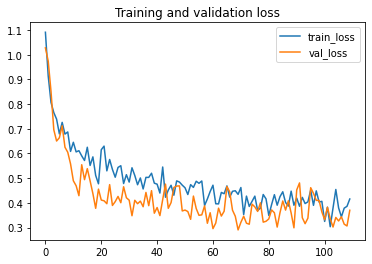

14/14 [==============================] - 3s 186ms/step - loss: 0.3583 - accuracy: 0.8611


In [20]:
for x in range(len(batch_size_arr)):
    
    #for batch size values
    if len(param_arr) == 0:
        param_arr.append([])
    
    for y in range(len(num_epochs_arr)):

        #for epoch values
        if len(param_arr) == 1:
            param_arr.append([])
        
        for z in range(len(lr_arr)):
            
            #for learning rate values
            if len(param_arr) == 2:
                param_arr.append([])
               
            print('')
            print("batch size: ", batch_size_arr[x])
            print("epochs: ", num_epochs_arr[y])
            print("learning rate: ", lr_arr[z])
            print('')
            
            #append the values per combo
            param_arr[0].append(batch_size_arr[x])
            param_arr[1].append(num_epochs_arr[y])
            param_arr[2].append(lr_arr[z])
            
            VALIDATION_ACCURACY = []
            VALIDATION_LOSS = []
            
            TRAIN_ACCURACY = []
            TRAIN_LOSS = []
            
            TEST_ACCURACY = []
            TEST_LOSS = []
            
            #change save_dir value per combination
            save_dir = savemodel()
            fold_var = 1
            
            for train_index, val_index in skf.split(np.zeros(len(df2)),Y):

                training_data = df2.iloc[train_index]
                validation_data = df2.iloc[val_index]
                
                print('')
                print("Fold number " + str(fold_var))
                
                train_data_generator = imgdatagen.flow_from_dataframe(training_data, directory = train_dir,
                                       x_col = "filename", y_col = "label",
                                       class_mode = "categorical", target_size = (224,224), batch_size = batch_size_arr[x],
                                            shuffle = True)
                valid_data_generator  = imgdatagen.flow_from_dataframe(validation_data, directory = train_dir,
                                        x_col = "filename", y_col = "label",
                                        class_mode = "categorical", target_size = (224,224), batch_size = batch_size_arr[x],
                                            shuffle = True)
                
                """
                test_data = df3
                
                test_data_preprocessed = imgdatagen2.flow_from_dataframe(test_data, directory = test_dir,
                                         x_col = "filename", y_col = "label",
                                         class_mode = "categorical", target_size = (224,224), batch_size = batch_size_arr[x],
                                            shuffle = True)
                """
                
                full_model = create_model()
                # Compile the model
                full_model.compile(loss='categorical_crossentropy',
                              optimizer=keras.optimizers.Adamax(learning_rate=lr_arr[z]),
                              metrics=['accuracy']) #categorical_crossentropy cause it is more than 2 classes

                # Create callbacks
                checkpoint = tf.keras.callbacks.ModelCheckpoint((save_dir+"/"+ "model_" + str(fold_var) + ".h5"), 
                                        monitor='val_accuracy', verbose=1, 
                                        save_best_only=True, mode='max')
                callbacks_list = [checkpoint]
                # This saves the best model


                # Fit the model
                history = full_model.fit(train_data_generator,
                                         epochs=num_epochs_arr[y],
                                         callbacks=callbacks_list,
                                         validation_data=valid_data_generator,
                                         verbose=1)

                # Plot the history
                plot_history(history, yrange=(0.2,1))

                # Load the best model instance to evaluate the performance of the model
                full_model.load_weights(save_dir+"/model_"+str(fold_var)+".h5")

                results = full_model.evaluate(valid_data_generator)
                results = dict(zip(full_model.metrics_names,results))
                
                # Store Validation accuracy/loss
                VALIDATION_ACCURACY.append(results['accuracy'])
                VALIDATION_LOSS.append(results['loss'])
                
                # Store Train accuracy/loss
                TRAIN_ACCURACY.append(np.mean(history.history['accuracy']))
                TRAIN_LOSS.append(np.mean(history.history['loss']))
                
                # Predict test set to get the test accuracy/loss
                yhat_probs = full_model.predict(testX, verbose=0) 
                yhat_classes = yhat_probs.argmax(axis=-1)
                
                # Test accuracy and loss score
                accuracy = accuracy_score(yt, yhat_classes)
                loss = log_loss(yt, yhat_probs)
                
                # Store Test accuracy and loss
                TEST_ACCURACY.append(accuracy)
                TEST_LOSS.append(loss)
                
                tf.keras.backend.clear_session()

                fold_var += 1
                
            val_acc_arr.append(VALIDATION_ACCURACY)
            val_loss_arr.append(VALIDATION_LOSS)
            
            train_acc_arr.append(TRAIN_ACCURACY)                            
            train_loss_arr.append(TRAIN_LOSS)
            
            test_acc_arr.append(TEST_ACCURACY)
            test_loss_arr.append(TEST_LOSS)

In [21]:
#stopper

### Display Values Per Combination of Hyperparameters

We will put the combination of hyperparameters and the resulting means of accuracy and loss together in a dataframe in order to display it nicely.

In [22]:
#append means of accuracy and loss sets per combo
for x in range(len(val_acc_arr)):
    val_acc_means.append(np.mean(val_acc_arr[x]))                                
    val_loss_means.append(np.mean(val_loss_arr[x]))
    
    train_acc_means.append(np.mean(train_acc_arr[x]))                              
    train_loss_means.append(np.mean(train_loss_arr[x]))                             

    test_acc_means.append(np.mean(test_acc_arr[x]))                               
    test_loss_means.append(np.mean(test_loss_arr[x])) 
    
df_hyperparam = pd.DataFrame(list(zip(param_arr[0],param_arr[1],param_arr[2],
                                      train_acc_means, train_loss_means,
                                      val_acc_means,val_loss_means,
                                      test_acc_means, test_loss_means))
                             ,columns=['batch size','number of epoch', 'learning rate', 
                                       'train accuracy', 'train loss',
                                       'val accuracy', 'val loss',
                                       'test accuracy', 'test loss'])

df_hyperparam = df_hyperparam.sort_values(ascending=False,by = 'val accuracy')

#df_hyperparam.to_excel("hyperparam_result.xlsx")

df_hyperparam

,batch size,number of epoch,learning rate,train accuracy,train loss,val accuracy,val loss,test accuracy,test loss
0,8,110,0.0001,0.807121,0.471852,0.82963,0.41044,0.853333,0.363935


In [23]:
#stopper

### Each fold results of best combination

Below are the validation accuracy and validation loss per fold and their average of the best combination.

In [24]:
#get the index of the best combination
comb_no = df_hyperparam.loc[[df_hyperparam['val accuracy'].idxmax()]].index.tolist()[0]
fold_num = [*range(1,6)]

fold_eval = pd.DataFrame(list(zip(fold_num,train_acc_arr[comb_no],train_loss_arr[comb_no],
                                  val_acc_arr[comb_no],val_loss_arr[comb_no],
                                  test_acc_arr[comb_no],test_loss_arr[comb_no]))
                         ,columns=['fold','Training Accuracy','Training Loss',
                                   'Validation Accuracy','Validation Loss',
                                   'Test Accuracy','Test Loss'])

fold_eval.set_index('fold', inplace=True)
fold_eval.loc['mean'] = fold_eval.mean()

#fold_eval.to_excel('fold_eval.xlsx')
fold_eval

,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Test Accuracy,Test Loss
fold,,,,,,
1,0.809154,0.469310,0.842593,0.366840,0.866667,0.431096
2,0.812332,0.461170,0.824074,0.436104,0.883333,0.294909
3,0.811490,0.463334,0.824074,0.406146,0.850000,0.387514
4,0.802673,0.479053,0.796296,0.484777,0.833333,0.364309
5,0.799958,0.486392,0.861111,0.358333,0.833333,0.341849
mean,0.807121,0.471852,0.829630,0.410440,0.853333,0.363935


In [25]:
#stopper

## Final Model

We will use the best combination of hypaparameters to train our final model. We will evaluate the model using the train set.

### Define plot history for final model training and validation

In [59]:
def plot_history2(history, yrange):
    #Plot loss and accuracy as a function of the epoch,
    #for the training and validation datasets.
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"]  = 1.25
    
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and test accuracy')
    plt.legend(['train_accuracy','test_accuracy'])
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and test loss')
    plt.legend(['train_loss','test_loss'])
    
    plt.show()

### Get best combination of hyperparameters

In [61]:
df_bestohypaparamu = df_hyperparam.loc[[df_hyperparam['val accuracy'].idxmax()]]

bestohypaparamu = [df_bestohypaparamu['batch size'].values[0],
                   df_bestohypaparamu['number of epoch'].values[0],
                   df_bestohypaparamu['learning rate'].values[0]]

#print(bestohypaparamu)

### Train and evaluate the model

In [112]:
# Split train set to train set and valid set
X = df2[['filename']]
y = df2[['label']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

In [113]:
#folder to store the train and test set folders
fortraintest2 = directory + "/ToBeUsedFinalModel"
if not os.path.exists(fortraintest2):
    os.makedirs(fortraintest2)

#train set folder
tr = fortraintest2 + "/train_set"
if not os.path.exists(tr):
    os.makedirs(tr)
else:
    #remove previous folder and create new one
    shutil.rmtree(tr)
    os.makedirs(tr)
    
#test set folder
va = fortraintest2 + "/val_set"
if not os.path.exists(va):
    os.makedirs(va)
else:
    #remove previous folder and create new one
    shutil.rmtree(va)
    os.makedirs(va)

#copying the images to the train set folder
for index, row in X_train.iterrows():
    trcpy = shutil.copy2(row['filename'], tr)
    X_train.loc[X_train['filename']==row['filename'],'filename']=trcpy #change to directory where image is copied
    
#copying the images to the test set folder
for index, row in X_val.iterrows():
    vacpy = shutil.copy2(row['filename'], va)
    X_val.loc[X_val['filename']==row['filename'],'filename']=vacpy #change to directory where image is copied

In [114]:
df4 = pd.concat([X_train,y_train],axis=1)
df4

,filename,label
547,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,2
382,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
218,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
549,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,2
468,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,2
...,...,...
322,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
269,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
127,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,0
442,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,2


In [115]:
counto = [0,0,0]

counto_count = 0

for x in df4['label'].unique():
    for y in df4['label']:
        if x == y:
            if counto_count == 0:
                counto[0] += 1
            elif counto_count == 1:
                counto[1] += 1
            else:
                counto[2] += 1
                
    counto_count += 1
    
print(counto)

[144, 144, 144]


In [116]:
df5 = pd.concat([X_val,y_val],axis=1)
df5

,filename,label
420,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,2
27,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,0
240,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
306,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
354,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
...,...,...
34,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,0
199,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,0
336,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,1
67,C:/Users/user/Desktop/Dataset/ToBeUsedFinalMod...,0


In [117]:
counto = [0,0,0]

counto_count = 0

for x in df5['label'].unique():
    for y in df5['label']:
        if x == y:
            if counto_count == 0:
                counto[0] += 1
            elif counto_count == 1:
                counto[1] += 1
            else:
                counto[2] += 1
                
    counto_count += 1
    
print(counto)

[36, 36, 36]


Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/110
54/54 [==============================] - 14s 203ms/step - loss: 1.1011 - accuracy: 0.5440 - val_loss: 1.0054 - val_accuracy: 0.5278

Epoch 00001: val_accuracy improved from -inf to 0.52778, saving model to C:/Users/user/Desktop/Model/saved_finalmodel_1\finalmodel_1.h5
Epoch 2/110
54/54 [==============================] - 8s 153ms/step - loss: 0.8716 - accuracy: 0.6111 - val_loss: 0.9136 - val_accuracy: 0.5648

Epoch 00002: val_accuracy improved from 0.52778 to 0.56481, saving model to C:/Users/user/Desktop/Model/saved_finalmodel_1\finalmodel_1.h5
Epoch 3/110
54/54 [==============================] - 8s 146ms/step - loss: 0.8155 - accuracy: 0.6319 - val_loss: 0.8336 - val_accuracy: 0.6481

Epoch 00003: val_accuracy improved from 0.56481 to 0.64815, saving model to C:/Users/user/Desktop/Model/saved_finalmodel_1\finalmodel_1.h5
Epoch 4/110
54/54 [==============

54/54 [==============================] - 10s 183ms/step - loss: 0.4786 - accuracy: 0.7940 - val_loss: 0.4777 - val_accuracy: 0.8426

Epoch 00036: val_accuracy improved from 0.83333 to 0.84259, saving model to C:/Users/user/Desktop/Model/saved_finalmodel_1\finalmodel_1.h5
Epoch 37/110
54/54 [==============================] - 10s 191ms/step - loss: 0.4714 - accuracy: 0.8056 - val_loss: 0.4395 - val_accuracy: 0.8056

Epoch 00037: val_accuracy did not improve from 0.84259
Epoch 38/110
54/54 [==============================] - 11s 196ms/step - loss: 0.4422 - accuracy: 0.8218 - val_loss: 0.4477 - val_accuracy: 0.8056

Epoch 00038: val_accuracy did not improve from 0.84259
Epoch 39/110
54/54 [==============================] - 11s 209ms/step - loss: 0.4230 - accuracy: 0.8356 - val_loss: 0.3979 - val_accuracy: 0.8056

Epoch 00039: val_accuracy did not improve from 0.84259
Epoch 40/110
54/54 [==============================] - 10s 181ms/step - loss: 0.4161 - accuracy: 0.8287 - val_loss: 0.5320 - v

54/54 [==============================] - 12s 213ms/step - loss: 0.4380 - accuracy: 0.8148 - val_loss: 0.4336 - val_accuracy: 0.8056

Epoch 00076: val_accuracy did not improve from 0.85185
Epoch 77/110
54/54 [==============================] - 9s 159ms/step - loss: 0.3765 - accuracy: 0.8472 - val_loss: 0.4759 - val_accuracy: 0.7870

Epoch 00077: val_accuracy did not improve from 0.85185
Epoch 78/110
54/54 [==============================] - 11s 207ms/step - loss: 0.3657 - accuracy: 0.8611 - val_loss: 0.5221 - val_accuracy: 0.7963

Epoch 00078: val_accuracy did not improve from 0.85185
Epoch 79/110
54/54 [==============================] - 11s 195ms/step - loss: 0.3856 - accuracy: 0.8426 - val_loss: 0.5466 - val_accuracy: 0.7778

Epoch 00079: val_accuracy did not improve from 0.85185
Epoch 80/110
54/54 [==============================] - 11s 199ms/step - loss: 0.3614 - accuracy: 0.8519 - val_loss: 0.5153 - val_accuracy: 0.7500

Epoch 00080: val_accuracy did not improve from 0.85185
Epoch 81/

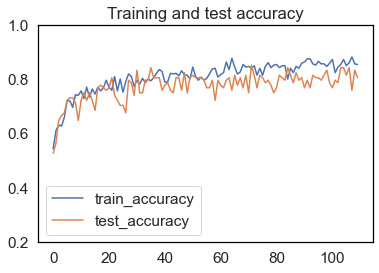

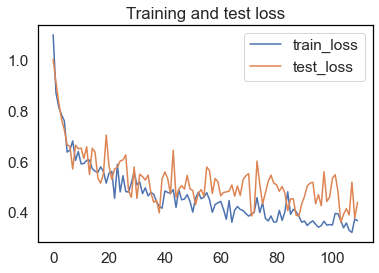

14/14 [==============================] - 2s 139ms/step - loss: 0.5008 - accuracy: 0.8426


In [118]:
TEST_ACCURACY = None
TEST_LOSS = None

train_dir = tr
valid_dir = va
save_dir = gen_dir + "/saved_finalmodel_1"

if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
    
os.makedirs(save_dir)

trainu = df4
validu = df5

train_data_generator = imgdatagen.flow_from_dataframe(trainu, directory = train_dir,
                                       x_col = "filename", y_col = "label",
                                       class_mode = "categorical", target_size = (224,224), batch_size = bestohypaparamu[0],
                                            shuffle = True)
valid_data_generator  = imgdatagen.flow_from_dataframe(validu, directory = valid_dir,
                        x_col = "filename", y_col = "label",
                        class_mode = "categorical", target_size = (224,224), batch_size = bestohypaparamu[0],
                            shuffle = True)

#print(len(train_data_generator))

full_model = create_model()
# Compile the model
full_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adamax(learning_rate=bestohypaparamu[2]),
              metrics=['accuracy']) #categorical_crossentropy cause it is more than 2 classes

# Create callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint((save_dir+"/"+ "finalmodel_1.h5"), 
                        monitor='val_accuracy', verbose=1, 
                        save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# This saves the best model


# Fit the model
history = full_model.fit(train_data_generator,
                         epochs=bestohypaparamu[1],
                         callbacks=callbacks_list,
                         validation_data=valid_data_generator,
                         verbose=1)

# Plot the history
plot_history2(history, yrange=(0.2,1))

# Load the best model instance to evaluate the performance of the model
full_model.load_weights(save_dir+"/"+ "finalmodel_1.h5")

results = full_model.evaluate(valid_data_generator)

#print(results)

results = dict(zip(full_model.metrics_names,results))

# Store Validation accuracy/loss
TEST_ACCURACY = results['accuracy']
TEST_LOSS = results['loss']

# Needed later for measuring performance metrics
# Predict test set to get the test accuracy/loss
yhat_probs2 = full_model.predict(testX, verbose=0) 
yhat_classes2 = yhat_probs.argmax(axis=-1)

tf.keras.backend.clear_session()

In [150]:
print("Test acc:  " + str(TEST_ACCURACY))
print("Test loss: " + str(TEST_LOSS))

Test acc:  0.8425925970077515
Test loss: 0.5008072853088379


## Measure Performance Metrics

After we have trained the final model with the entire train set and evaluate it using the test set, we can now measure the performance metrics.

In [142]:
#Metrics
def evaluato(yhat_probs2, 
             yhat_classes2 
            ):

    # accuracy: (tp + tn) / (p + n)
    matrix = confusion_matrix(yt, yhat_classes2)
    accuracy2 = matrix.diagonal()/matrix.sum(axis=1)
    print('Accuracy per class: ' + str(accuracy2))
    # precision tp / (tp + fp)
    precision = precision_score(yt, yhat_classes2, average="weighted")
    print('Precision: %f' % precision)
    precision2 = precision_score(yt, yhat_classes, average=None)
    print('Precision per class: ' + str(precision2))
    # recall: tp / (tp + fn)
    recall = recall_score(yt, yhat_classes2, average="weighted")
    print('Recall: %f' % recall)
    recall2 = recall_score(yt, yhat_classes, average=None)
    print('Recall per class: ' + str(recall2))
    
    
    #ROC AUC
    #-------------------------------------------------------------------------------
    # Binarize the true label
    ytbin = label_binarize(yt, classes=[0, 1, 2])
    n_classes = ytbin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
      
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytbin[:, i], yhat_probs2[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i]) 

    # Compute micro-average ROC curve and ROC area
    fpr["macro"], tpr["macro"], _ = roc_curve(ytbin.ravel(), yhat_probs2.ravel())
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"]  = 1.25
    
    #balut-penoy
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Balut-Penoy')
    plt.legend(loc="lower right")
    plt.show()

    #salted egg
    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Salted Egg')
    plt.legend(loc="lower right")
    plt.show()

    #table egg
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Table Egg')
    plt.legend(loc="lower right")
    plt.show()
    #-------------------------------------------------------------------------------
    
    #confusion matrix
    matrix = confusion_matrix(yt, yhat_classes2)
    
    df_cm = pd.DataFrame(matrix, range(matrix.shape[0]), range(matrix.shape[1]))
    df_cm = df_cm.rename(columns={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'}, 
                         index={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'})
    
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title('Confusion Matrix of Final Model Evaluation')
    plt.show()
    
    return accuracy2, precision2, recall2

Accuracy per class: [0.9  0.95 0.65]
Precision: 0.859881
Precision per class: [0.94736842 0.7037037  0.92857143]
Recall: 0.833333
Recall per class: [0.9  0.95 0.65]


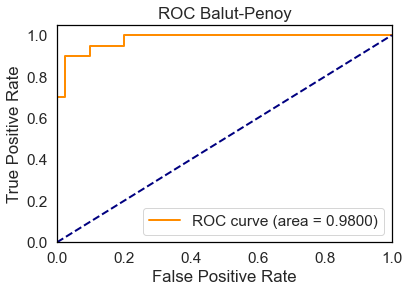

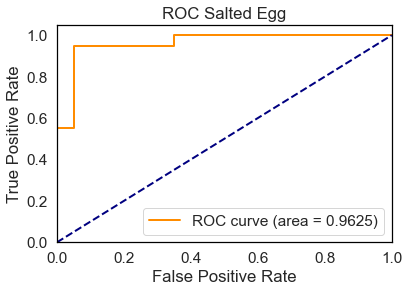

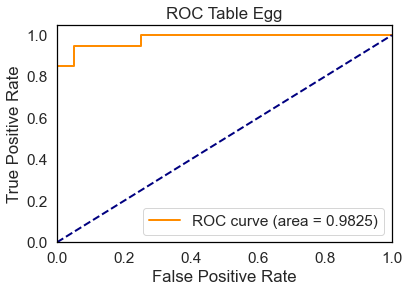

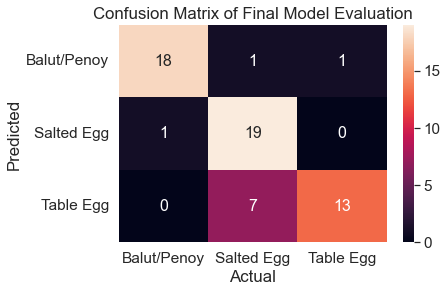

In [143]:
accuracy2, precision2, recall2 = evaluato(yhat_probs2, yhat_classes2)

### Metrics per Class

In [145]:
accuracy2 = list(accuracy2)
precision2 = list(precision2)
recall2 = list(recall2)

accuracy2.append(0)
precision2.append(0)
recall2.append(0)

classes = 3

for x in range(classes):
    accuracy2[-1] += accuracy2[x]
    precision2[-1] += precision2[x]
    recall2[-1] += recall2[x]

accuracy2[-1] = accuracy2[-1]/classes
precision2[-1] = precision2[-1]/classes
recall2[-1] = recall2[-1]/classes

In [147]:
label = ['Balut/Penoy','Salted','Table','Ave']

df_eval_per_class = pd.DataFrame(data = list(zip(label,accuracy2,precision2,recall2)), 
                       columns=["Class","Accuracy","Precision","Recall"])

#set fold_ave as the index
df_eval_per_class.set_index("Class",inplace=True)

df_eval_per_class

,Accuracy,Precision,Recall
Class,,,
Balut/Penoy,0.900000,0.947368,0.900000
Salted,0.950000,0.703704,0.950000
Table,0.650000,0.928571,0.650000
Ave,0.833333,0.859881,0.833333


## Validating Misclassified Images

We will display the correct and incorrect predictions. We will first get the images from the directories stored under the filename column.

In [218]:
testX2 = []

for img_path in X_test['filename']:
    img = cv2.imread(img_path)
    testX2.append(img)

testX2 = np.array(testX2)

We will be applying Grad-CAM in order to check where is the focus of the model. It presents a heatmap. The hotter the color is on a region, the more it is focused on.

### Grad-CAM algorithm

In [219]:
last_conv_layer_name = "conv5_block3_add"

preprocess_input = keras.applications.resnet50.preprocess_input

def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

### superimposed visualization

In [220]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

### Prediction

In [227]:
def guraducamu(img_dir):
    img_size = (224,224)

    # Prepare image
    img_array = get_img_array(img_dir, img_size)

    conv_model = keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

    for layer in conv_model.layers:
        layer.trainable = False

    x = keras.layers.GlobalAveragePooling2D()(conv_model.output)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    predictions = keras.layers.Dense(3, activation='softmax',name = "prediction")(x)

    model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

    model.load_weights(save_dir+"/"+ "finalmodel_1.h5")

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
 
    print("Original Image")
    display(Image(img_dir))

    print("Heatmap Prediction")
    plt.matshow(heatmap)
    plt.grid(False)
    plt.axis('off')
    plt.show()

    print("Grad-CAM")
    save_and_display_gradcam(img_dir, heatmap)

### Correct predictions

Found 50 correct labels
Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 79.jpg
Original Image


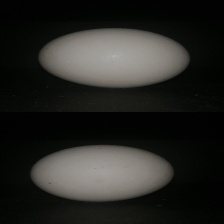

Heatmap Prediction


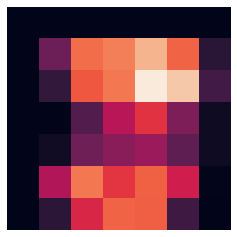

Grad-CAM


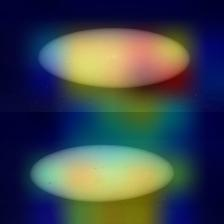

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 40.jpg
Original Image


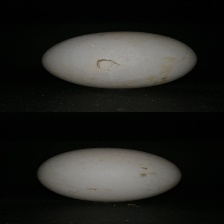

Heatmap Prediction


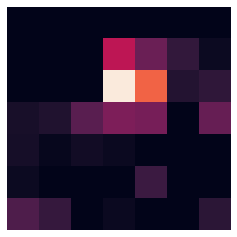

Grad-CAM


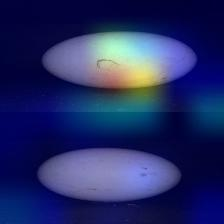

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 150.jpg
Original Image


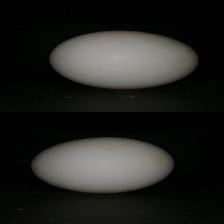

Heatmap Prediction


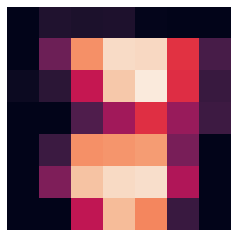

Grad-CAM


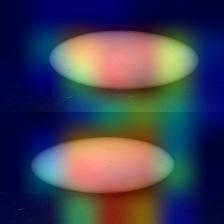

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 4.jpg
Original Image


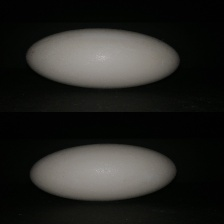

Heatmap Prediction


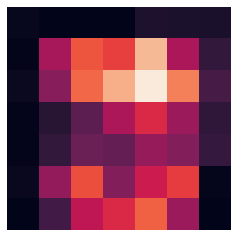

Grad-CAM


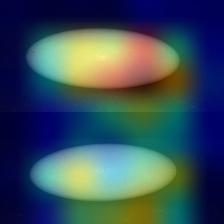

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 188.jpg
Original Image


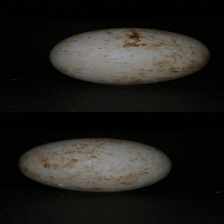

Heatmap Prediction


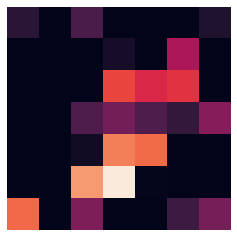

Grad-CAM


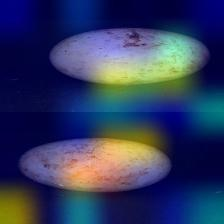

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 108.jpg
Original Image


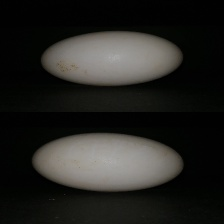

Heatmap Prediction


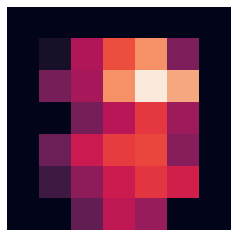

Grad-CAM


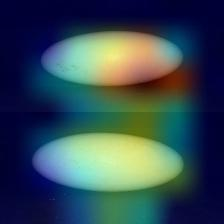

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 58.jpg
Original Image


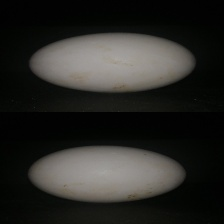

Heatmap Prediction


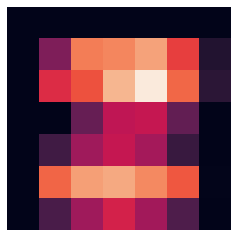

Grad-CAM


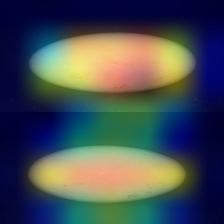

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 32.jpg
Original Image


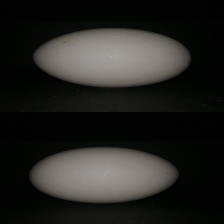

Heatmap Prediction


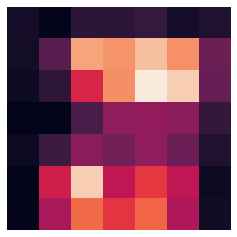

Grad-CAM


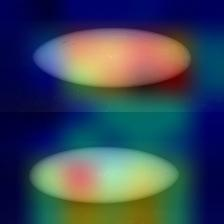

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 52.jpg
Original Image


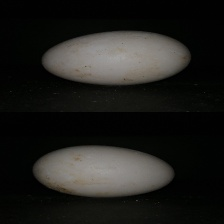

Heatmap Prediction


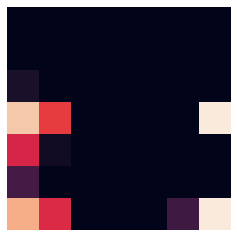

Grad-CAM


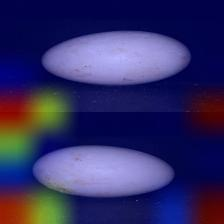

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 167.jpg
Original Image


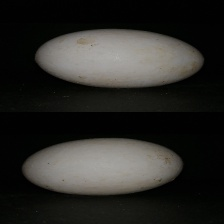

Heatmap Prediction


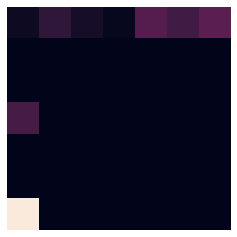

Grad-CAM


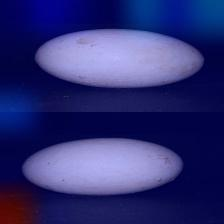

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 47.jpg
Original Image


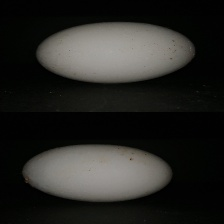

Heatmap Prediction


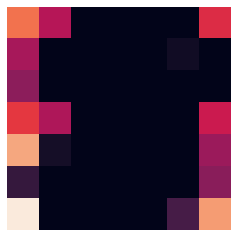

Grad-CAM


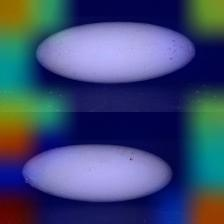

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 56.jpg
Original Image


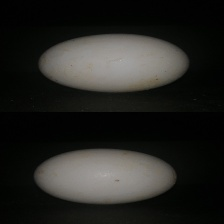

Heatmap Prediction


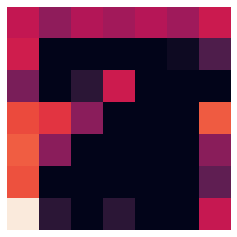

Grad-CAM


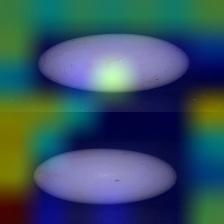

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 156.jpg
Original Image


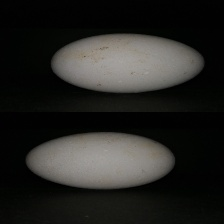

Heatmap Prediction


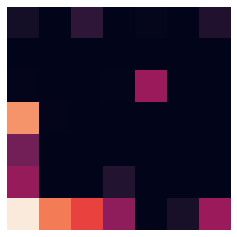

Grad-CAM


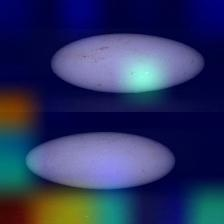

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 6.jpg
Original Image


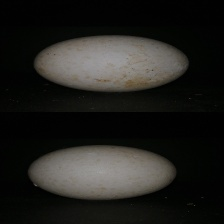

Heatmap Prediction


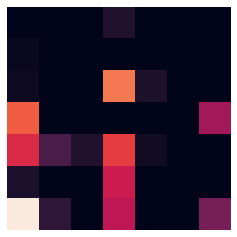

Grad-CAM


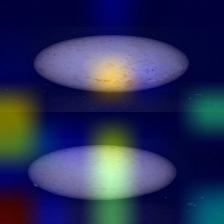

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 119.jpg
Original Image


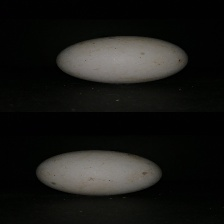

Heatmap Prediction


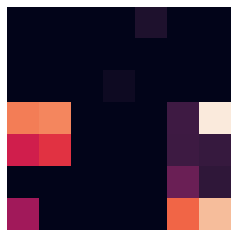

Grad-CAM


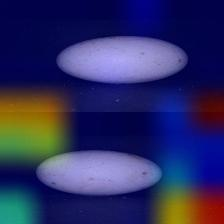

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 123.jpg
Original Image


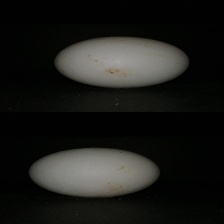

Heatmap Prediction


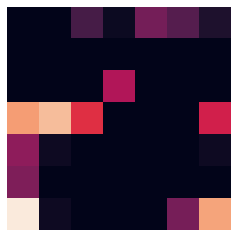

Grad-CAM


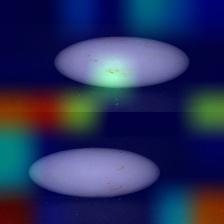

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 22.jpg
Original Image


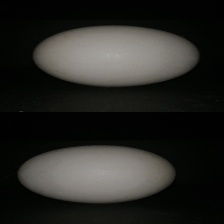

Heatmap Prediction


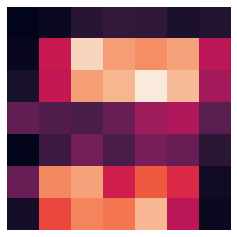

Grad-CAM


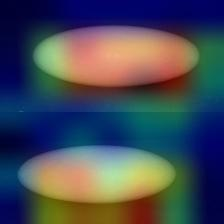

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 64.jpg
Original Image


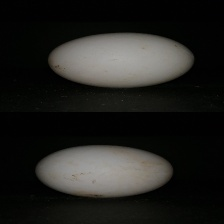

Heatmap Prediction


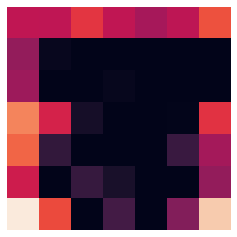

Grad-CAM


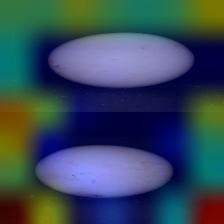

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 32.jpg
Original Image


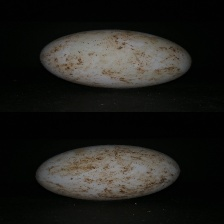

Heatmap Prediction


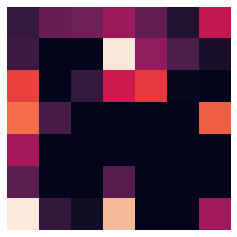

Grad-CAM


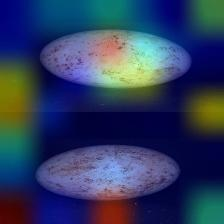

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 195.jpg
Original Image


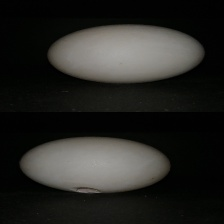

Heatmap Prediction


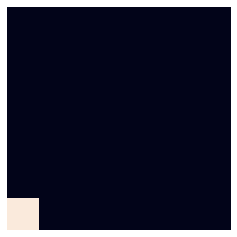

Grad-CAM


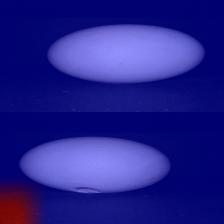

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 17.jpg
Original Image


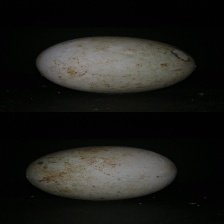

Heatmap Prediction


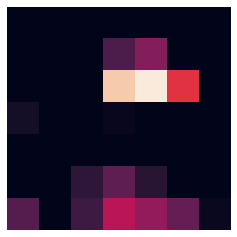

Grad-CAM


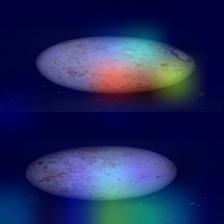

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 103.jpg
Original Image


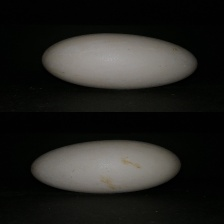

Heatmap Prediction


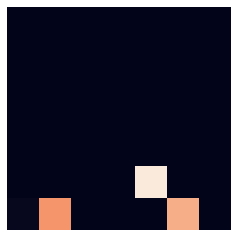

Grad-CAM


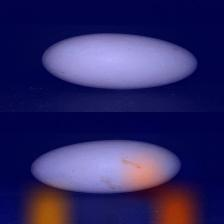

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 76.jpg
Original Image


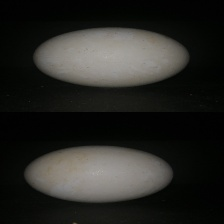

Heatmap Prediction


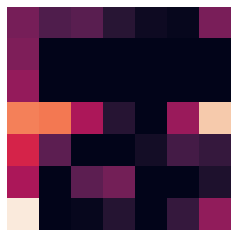

Grad-CAM


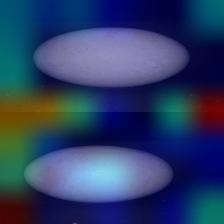

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 141.jpg
Original Image


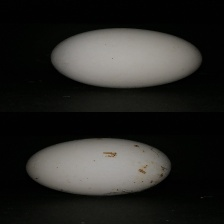

Heatmap Prediction


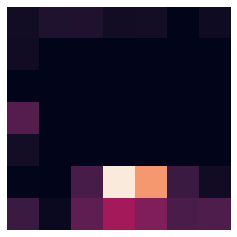

Grad-CAM


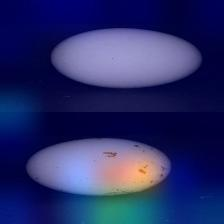

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 42.jpg
Original Image


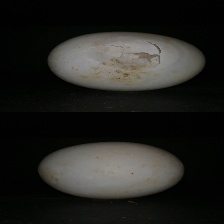

Heatmap Prediction


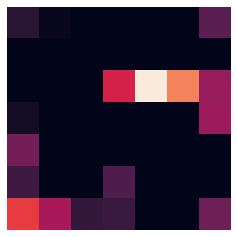

Grad-CAM


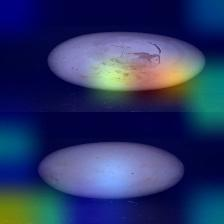

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 8.jpg
Original Image


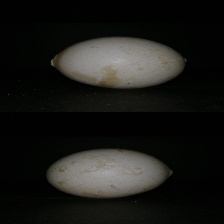

Heatmap Prediction


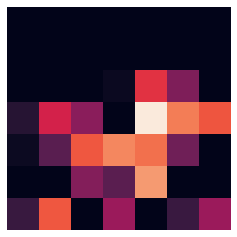

Grad-CAM


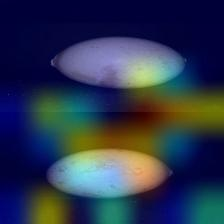

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 155.jpg
Original Image


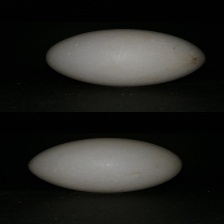

Heatmap Prediction


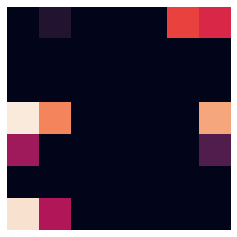

Grad-CAM


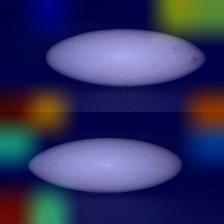

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 127.jpg
Original Image


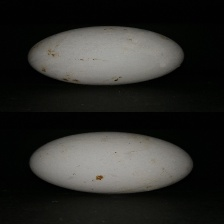

Heatmap Prediction


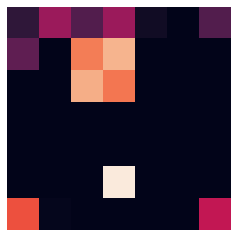

Grad-CAM


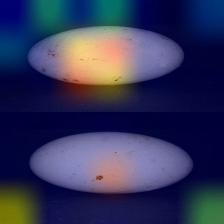

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 55.jpg
Original Image


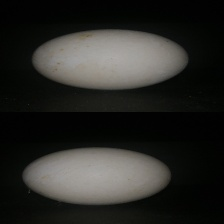

Heatmap Prediction


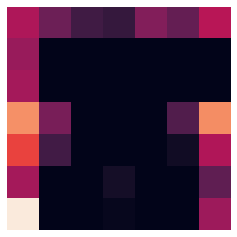

Grad-CAM


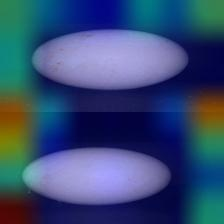

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 193.jpg
Original Image


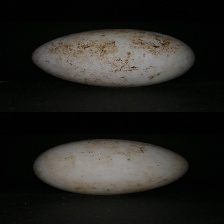

Heatmap Prediction


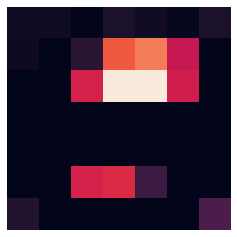

Grad-CAM


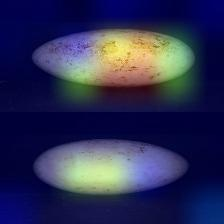

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 93.jpg
Original Image


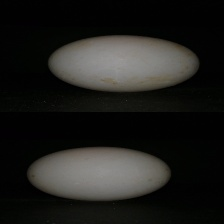

Heatmap Prediction


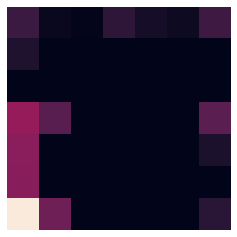

Grad-CAM


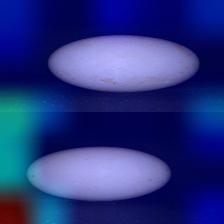

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 164.jpg
Original Image


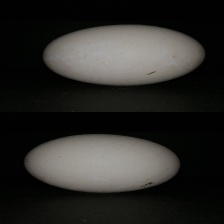

Heatmap Prediction


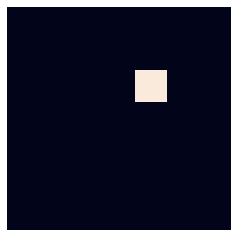

Grad-CAM


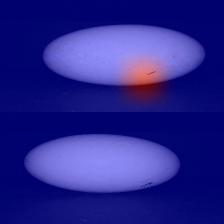

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 176.jpg
Original Image


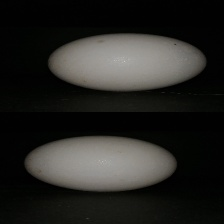

Heatmap Prediction


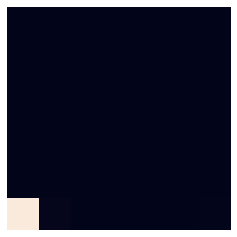

Grad-CAM


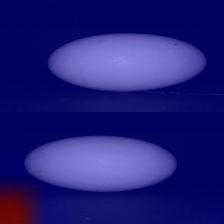

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 33.jpg
Original Image


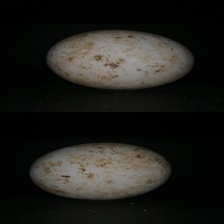

Heatmap Prediction


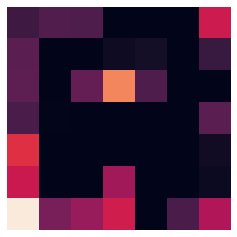

Grad-CAM


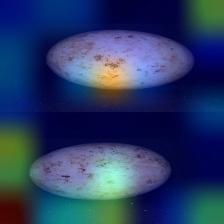

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 133.jpg
Original Image


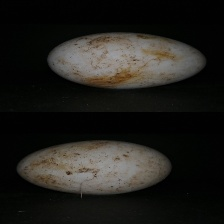

Heatmap Prediction


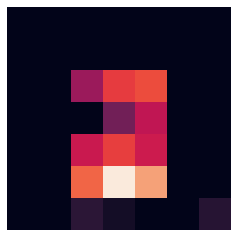

Grad-CAM


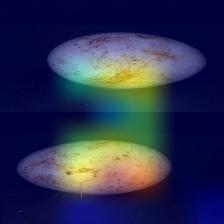

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 38.jpg
Original Image


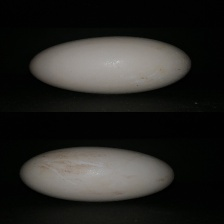

Heatmap Prediction


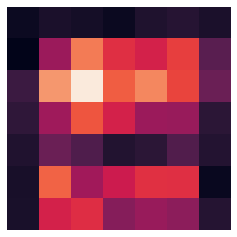

Grad-CAM


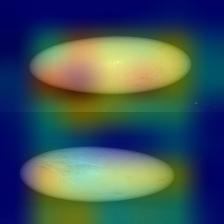

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 138.jpg
Original Image


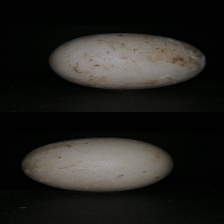

Heatmap Prediction


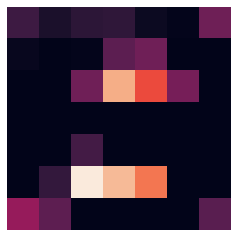

Grad-CAM


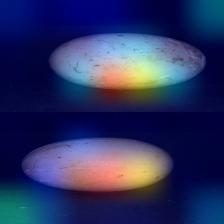

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 101.jpg
Original Image


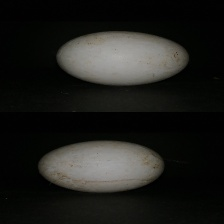

Heatmap Prediction


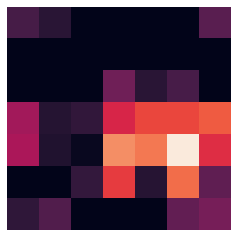

Grad-CAM


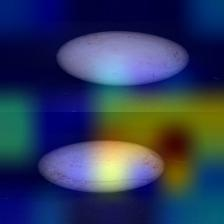

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 169.jpg
Original Image


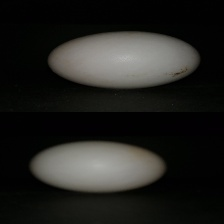

Heatmap Prediction


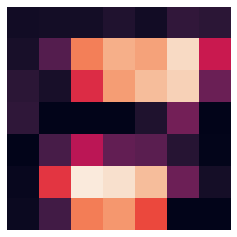

Grad-CAM


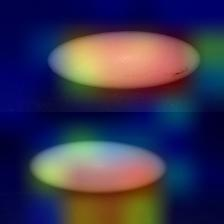

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 49.jpg
Original Image


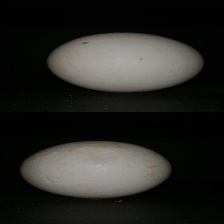

Heatmap Prediction


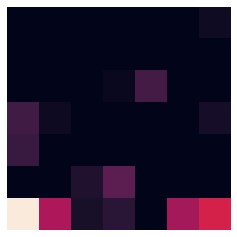

Grad-CAM


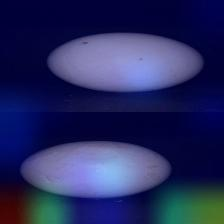

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 132.jpg
Original Image


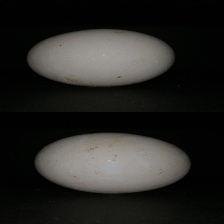

Heatmap Prediction


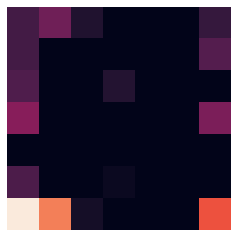

Grad-CAM


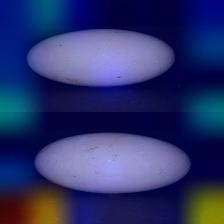

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 25.jpg
Original Image


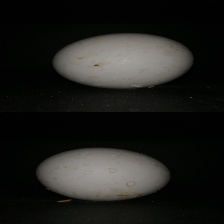

Heatmap Prediction


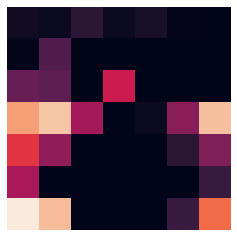

Grad-CAM


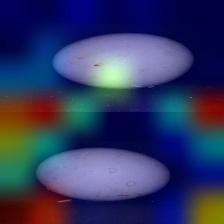

Predict 0, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 86.jpg
Original Image


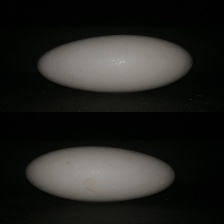

Heatmap Prediction


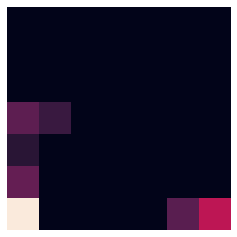

Grad-CAM


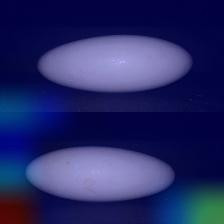

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 117.jpg
Original Image


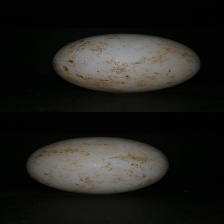

Heatmap Prediction


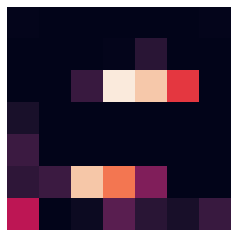

Grad-CAM


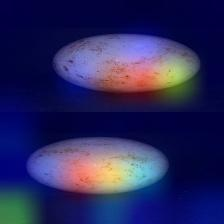

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 54.jpg
Original Image


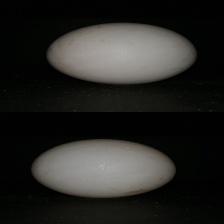

Heatmap Prediction


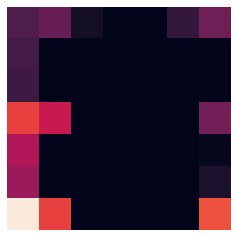

Grad-CAM


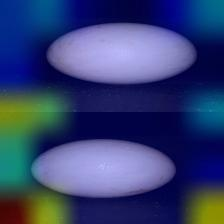

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 111.jpg
Original Image


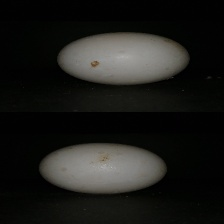

Heatmap Prediction


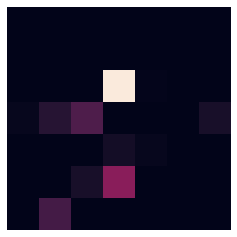

Grad-CAM


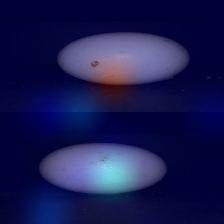

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 71.jpg
Original Image


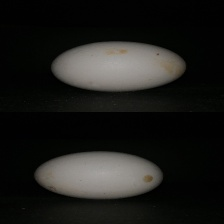

Heatmap Prediction


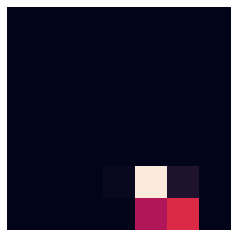

Grad-CAM


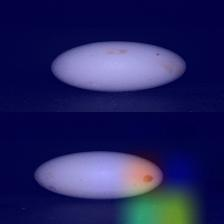

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 118.jpg
Original Image


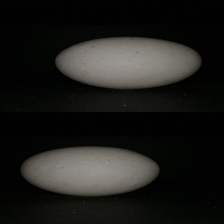

Heatmap Prediction


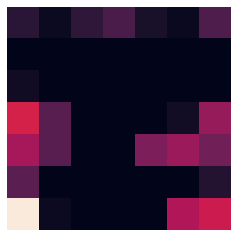

Grad-CAM


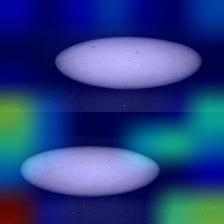

Predict 2, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 24.jpg
Original Image


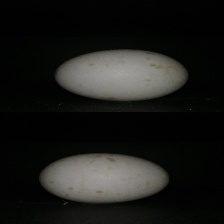

Heatmap Prediction


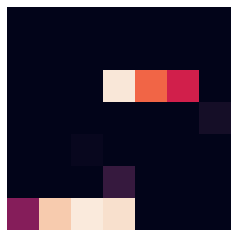

Grad-CAM


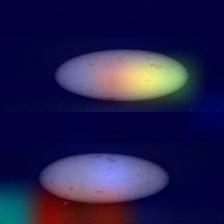

Predict 1, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 14.jpg
Original Image


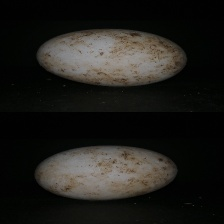

Heatmap Prediction


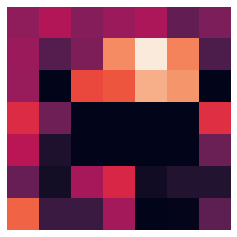

Grad-CAM


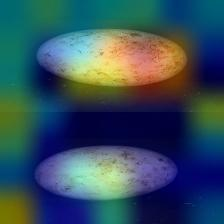

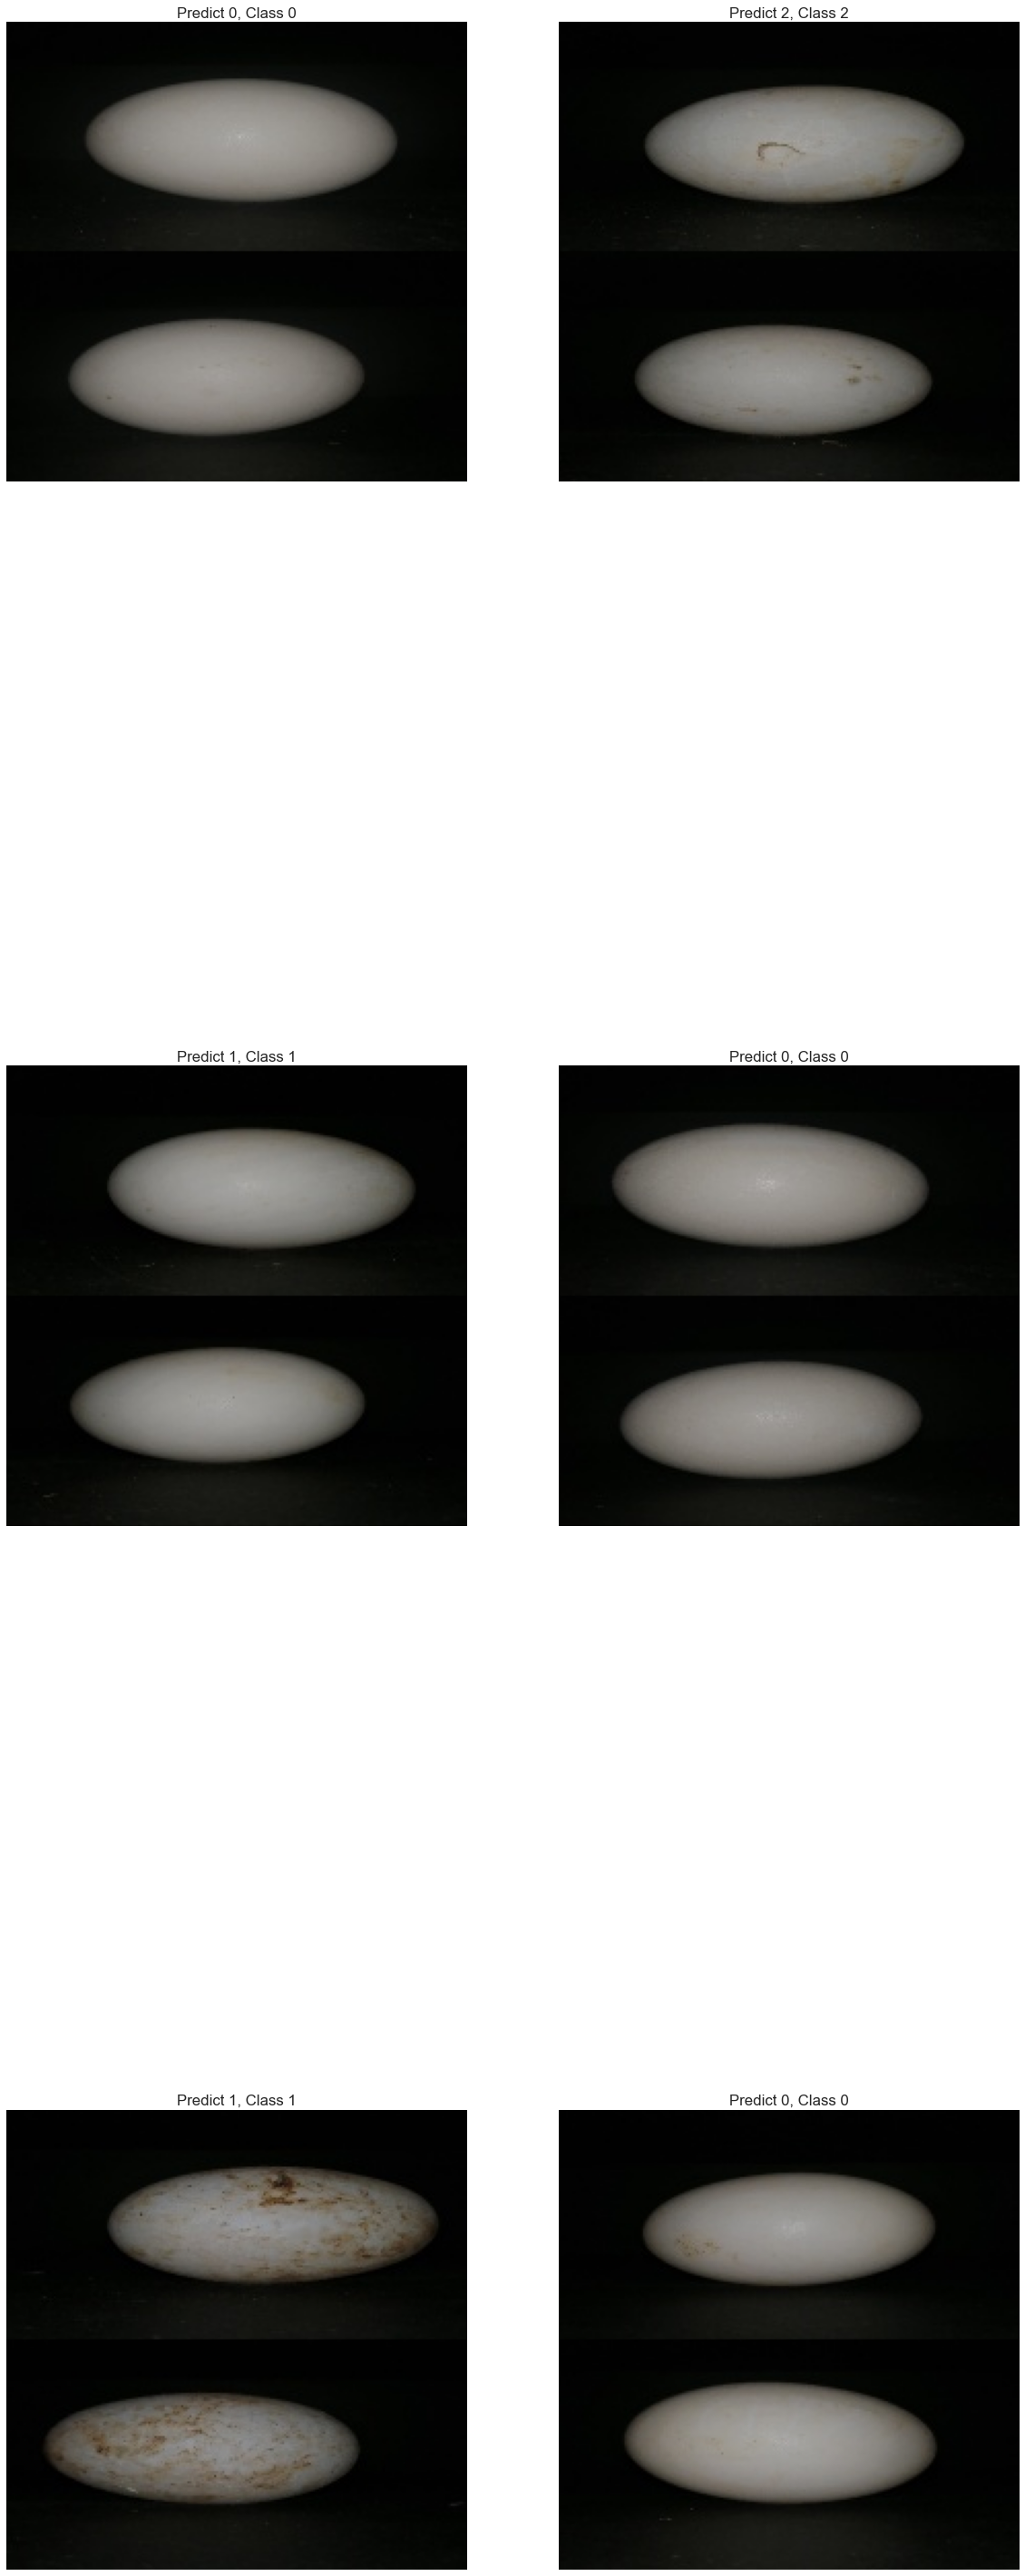

In [228]:
correct = np.where(yhat_classes2==yt)[0]

print("Found %d correct labels" % len(correct))

for x in correct:
    print("Predict {0}, Class {1}".format(str(yhat_classes2[x]),str(yt.values[x])))
    img_dir = X_test.iloc[x]['filename']
    print(img_dir)
    guraducamu(img_dir)
    
plt.figure(figsize=(20,60))
for i, correct in enumerate(correct[:6]):
    plt.subplot(3,2,i+1)
    RGB_img = cv2.cvtColor(testX2[correct], cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img) #, interpolation='none') #, cmap='gray')
    plt.title("Predict {0}, Class {1}".format(str(yhat_classes2[correct]),str(yt.values[correct])))
    plt.grid(False)
    plt.axis('off')

plt.show()

### Incorrect predictions

Found 10 incorrect labels
Predict 1, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 66.jpg
Original Image


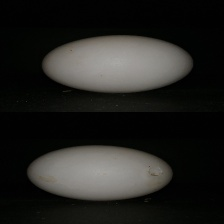

Heatmap Prediction


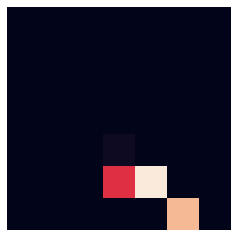

Grad-CAM


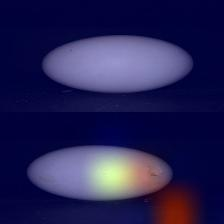

Predict 1, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 188.jpg
Original Image


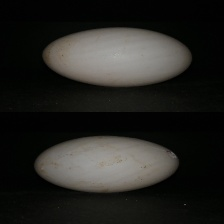

Heatmap Prediction


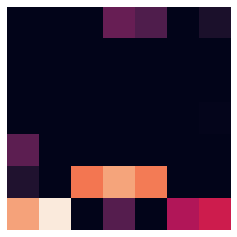

Grad-CAM


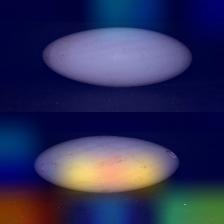

Predict 1, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 191.jpg
Original Image


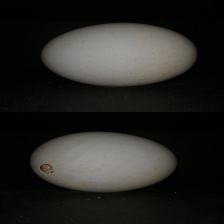

Heatmap Prediction


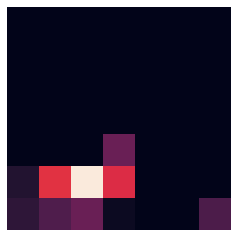

Grad-CAM


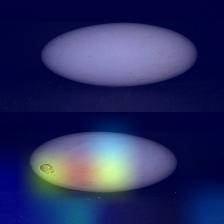

Predict 1, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 62.jpg
Original Image


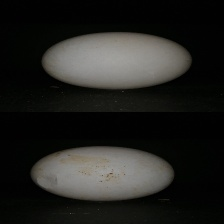

Heatmap Prediction


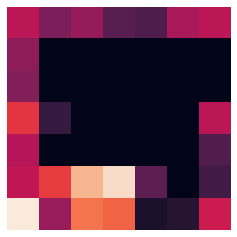

Grad-CAM


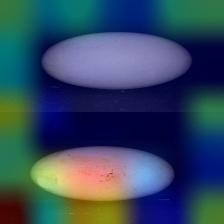

Predict 1, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 17.jpg
Original Image


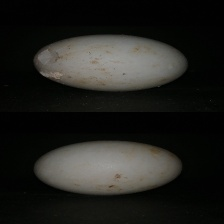

Heatmap Prediction


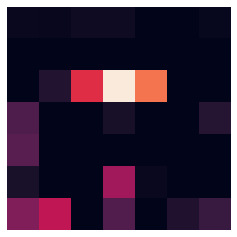

Grad-CAM


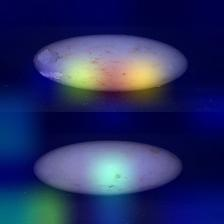

Predict 2, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 130.jpg
Original Image


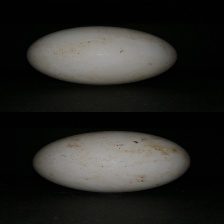

Heatmap Prediction


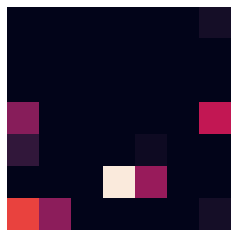

Grad-CAM


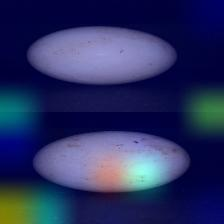

Predict 1, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 112.jpg
Original Image


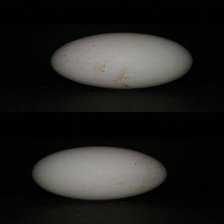

Heatmap Prediction


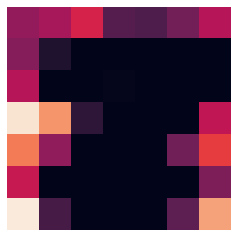

Grad-CAM


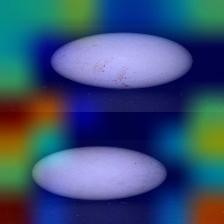

Predict 1, Class 2
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Table egg 39.jpg
Original Image


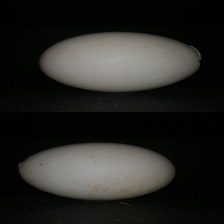

Heatmap Prediction


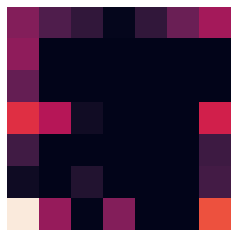

Grad-CAM


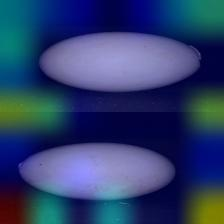

Predict 0, Class 1
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Salted egg 110.jpg
Original Image


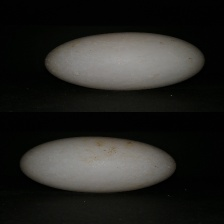

Heatmap Prediction


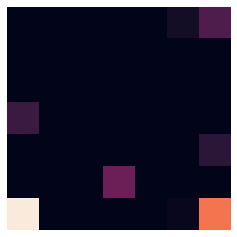

Grad-CAM


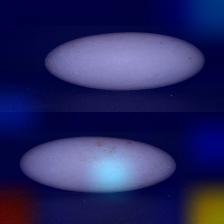

Predict 1, Class 0
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\Balut-penoy 98.jpg
Original Image


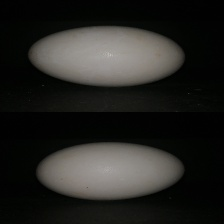

Heatmap Prediction


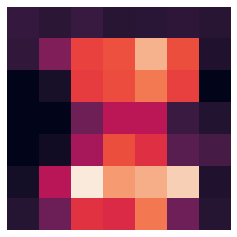

Grad-CAM


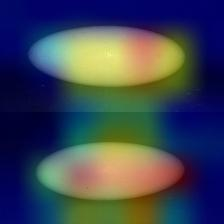

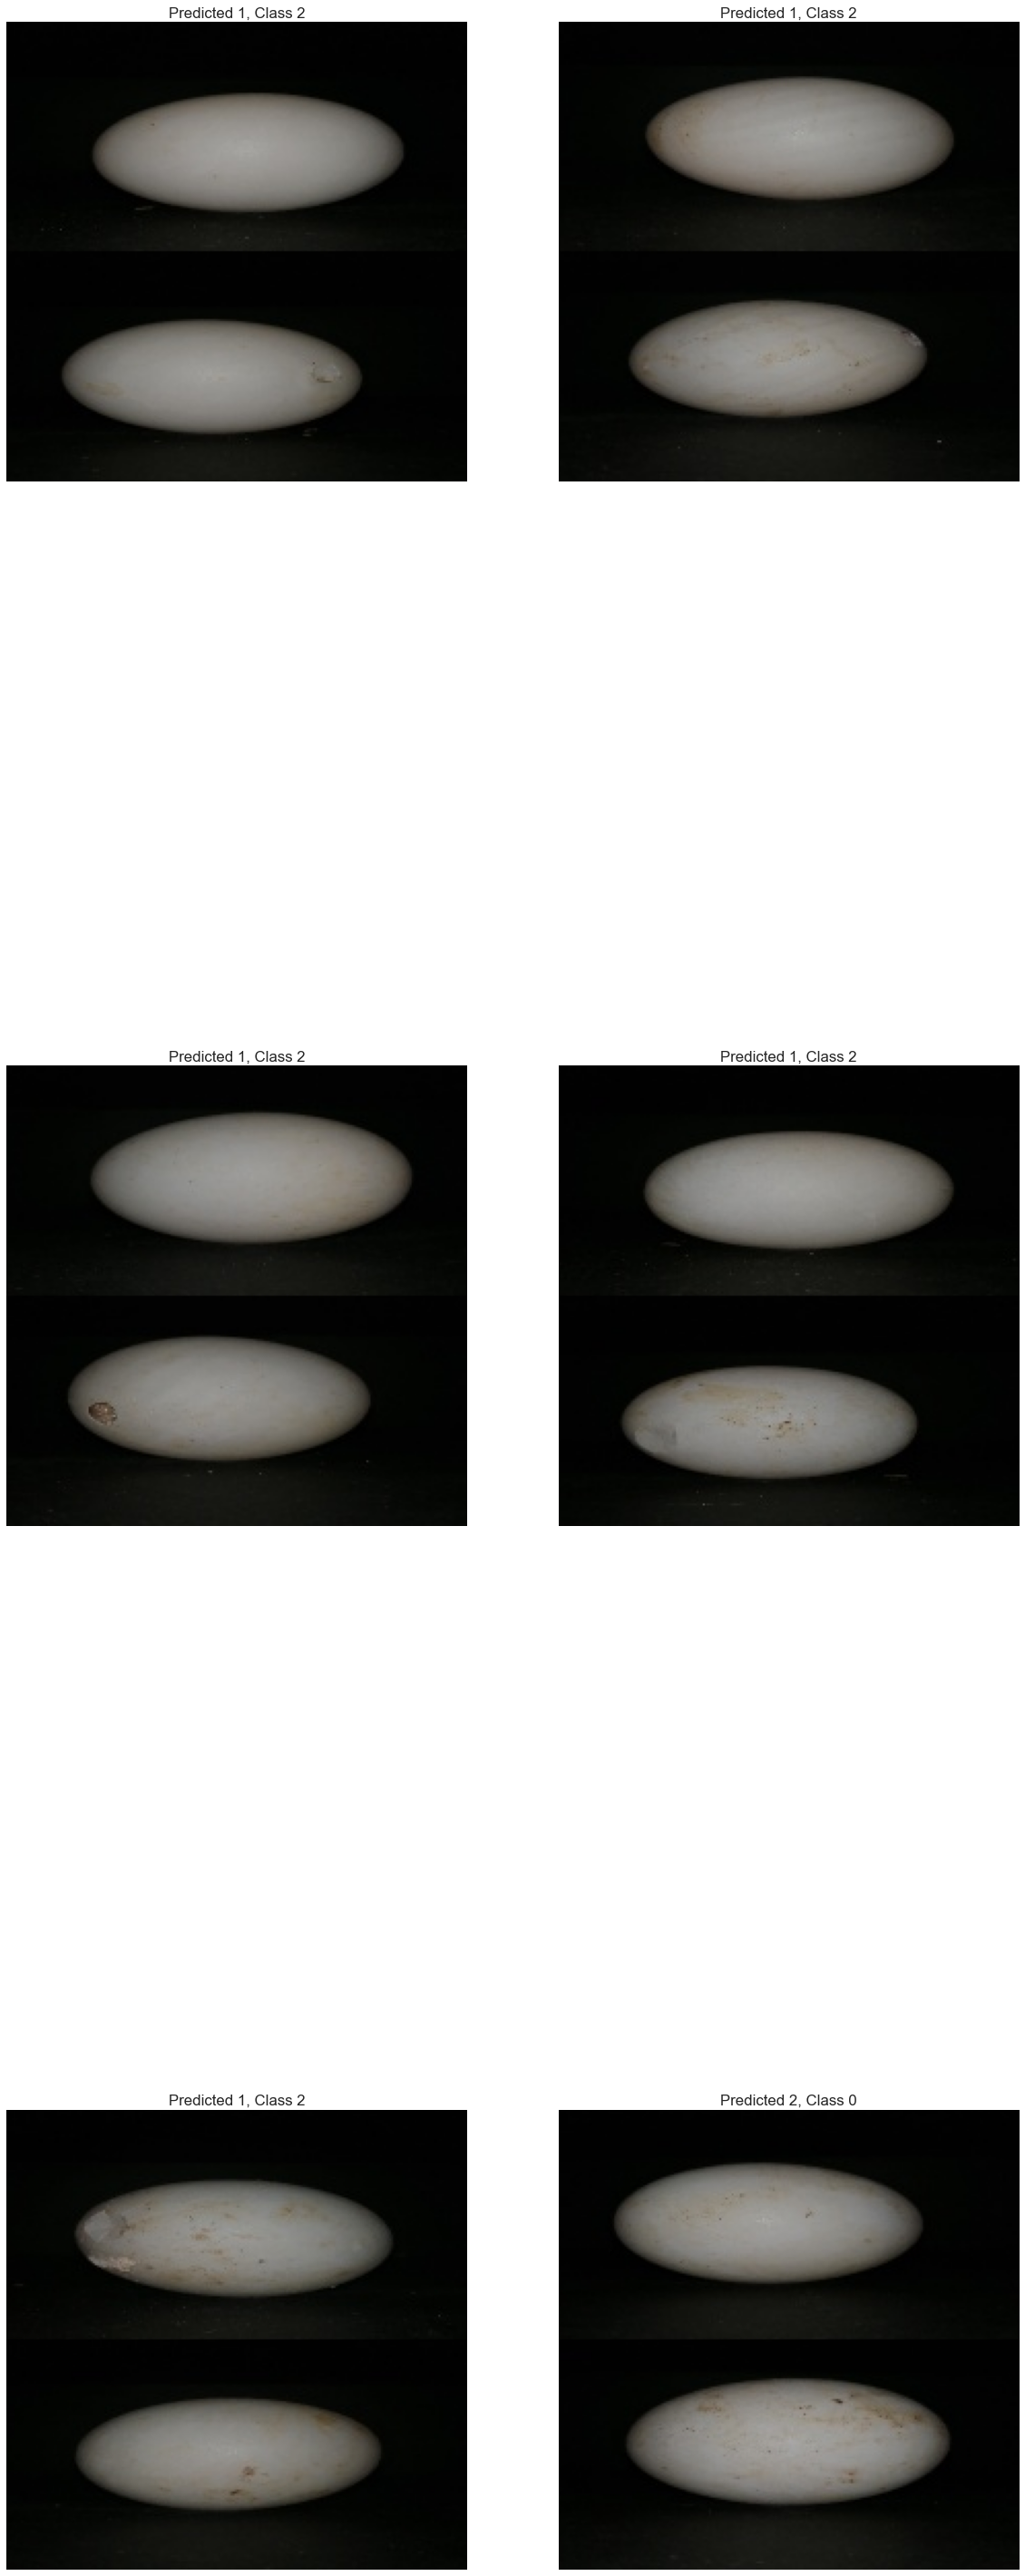

In [229]:
incorrect = np.where(yhat_classes2!=yt)[0]

print ("Found %d incorrect labels" % len(incorrect))

for x in incorrect:
    print("Predict {0}, Class {1}".format(str(yhat_classes2[x]),str(yt.values[x])))
    img_dir = X_test.iloc[x]['filename']
    print(img_dir)
    guraducamu(img_dir)

plt.figure(figsize=(20,60))
for i, incorrect in enumerate(incorrect[:6]):
    plt.subplot(3,2,i+1)
    RGB_img = cv2.cvtColor(testX2[incorrect], cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img) #, interpolation='none') #, cmap='gray')
    plt.title("Predicted {0}, Class {1}".format(str(yhat_classes2[incorrect]), str(yt.values[incorrect])))
    plt.grid(False)
    plt.axis('off')

plt.show()

In [33]:
stopper

NameError: name 'stopper' is not defined